In [1]:
import warnings
warnings.simplefilter('default')

# Import Packages

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

/Users/hpratama/opt/miniconda3/envs/jcopml/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in Pillow 9 (2022-01-02). Use __version__ instead.
  from PIL import PILLOW_VERSION
/Users/hpratama/opt/miniconda3/envs/jcopml/lib/python3.7/site-packages/ipywidgets/widgets/widget_selection.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, Iterable


In [3]:
import lasio
import os
import matplotlib.pyplot as plt
import seaborn as sns
from math import isnan

In [4]:
from jcopml.plot import plot_actual_vs_prediction, plot_correlation_matrix, plot_residual

# Read .las Files

In [5]:
from tqdm.auto import tqdm

In [6]:
lasDic = {}
for filename in tqdm(os.listdir(os.getcwd()), desc='.las File'):
    if filename.endswith(".las"):
        lasDic[filename] = lasio.read(filename)

In [7]:
#check file versions
for filename in lasDic:
    las = lasDic[filename]
    print(las.version)

Mnemonic  Unit  Value  Description                           
--------  ----  -----  -----------                           
VERS            2.0    CWLS log ASCII Standard -VERSION 2.0  
WRAP            NO     One line per depth step               
DLM             SPACE  Column Data Section Delimiter         
Mnemonic  Unit  Value  Description                           
--------  ----  -----  -----------                           
VERS            2.0    CWLS log ASCII Standard -VERSION 2.0  
WRAP            NO     One line per depth step               
DLM             SPACE  Column Data Section Delimiter         
Mnemonic  Unit  Value  Description                           
--------  ----  -----  -----------                           
VERS            2.0    CWLS log ASCII Standard -VERSION 2.0  
WRAP            NO     One line per depth step               
DLM             SPACE  Column Data Section Delimiter         
Mnemonic  Unit  Value  Description                           
--------

# EDA

## Well Location

In [9]:
#Extract well locations
#NOTE: well locations are offset by a constant latitude/longitude to make them non-traceable
#however, their relative distance is preserved.

Lat = []
Lon = []
for filename in lasDic:
    las = lasDic[filename]
    Lat.append(las.well['SLAT'].value)
    Lon.append(las.well['SLON'].value)

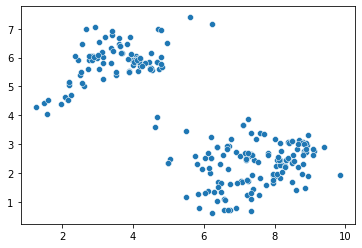

In [10]:
sns.scatterplot(x=Lon, y=Lat);

Take a look at each file mnemonic and their description.

In [17]:
for filename in lasDic:
    las = lasDic[filename]
    print(las.curves)

Mnemonic  Unit  Value  Description               
--------  ----  -----  -----------               
DEPT      F            1 MEASURED DEPTH          
DTCO      US/F         DELTA-T COMPRESSIONAL     
GRS       GAPI         GAMMA RAY FROM SONIC LOG  
DTSM      US/F         DELTA-T SHEAR             
Mnemonic  Unit  Value  Description                                                 
--------  ----  -----  -----------                                                 
DEPT      F                                                                        
HLLD      OHMM         LATEROLOG DEEP RES.                                         
HLLS      OHMM         LATEROLOG SHALLOW RES.                                      
RXOZ      OHMM         FLUSHED ZONE RESISTIVITY                                    
GRR       GAPI         GAMMA RAY FROM RES.                                         
GRD       GAPI         GAMMA RAY FROM DENSITY LOG                                  
RHOZ      G/C3         HILT 

Count the times each mnemonic appears in the set of all files.

In [34]:
curveCount = {}
for filename in lasDic:
    las = lasDic[filename]
    for item in las.curves.iteritems():
        if item[0] in curveCount.keys():
            curveCount[item[0]] += 1
        else:
            curveCount[item[0]] = 1

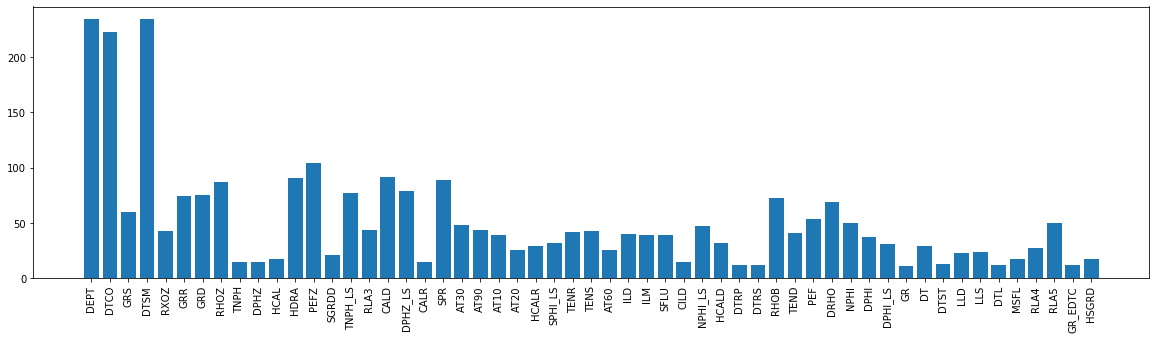

In [43]:
keys = []
for key in curveCount:
    if curveCount[key] > 10:
        keys.append(key)
values = [curveCount[key] for key in keys]
plt.figure(figsize=(20, 5))
plt.bar(keys, values,)
plt.xticks(rotation=90)
plt.show()


Instead of counting the number of times a given mnemonic appears in the entire wells dataset, we can count how many times a given unit of measurement (which is associated with a mnemonic appears). This may be useful because several mnemonics can have the same units and can possibly represent the same physical measure.

In [44]:
unitCount = {}
for filename in lasDic:
    las = lasDic[filename]
    for item in las.curves.iteritems():
        if item[1].unit in unitCount.keys():
            unitCount[item[1].unit] += 1
        else:
            unitCount[item[1].unit] = 1

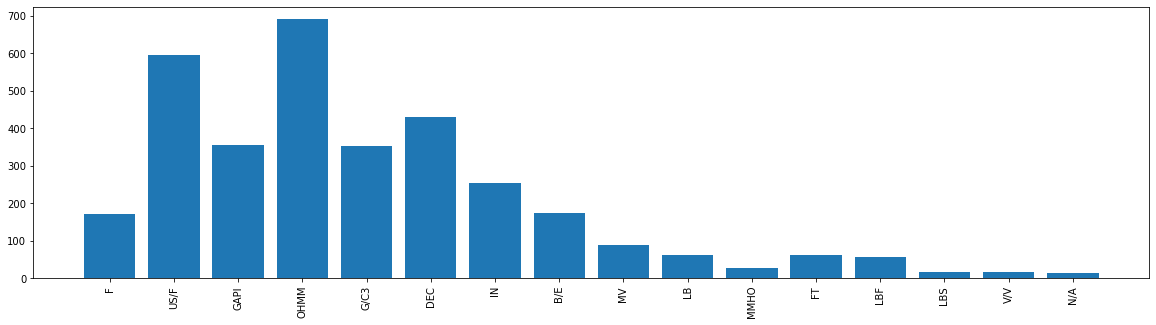

In [45]:
keys = []
for key in unitCount:
    if unitCount[key] > 10:
        keys.append(key)
values = [unitCount[key] for key in keys]
plt.figure(figsize=(20, 5))
plt.bar(keys, values)
plt.xticks(rotation=90)
plt.show()


Alternatively, we can count how many times a unit appears in the whole dataset but counting it for every well only once.

In [46]:
unitCount = {}
for filename in lasDic:
    las = lasDic[filename]
    unitset = set()
    for item in las.curves.iteritems():
        unitset.add(item[1].unit)
    for item in unitset:
        if item in unitCount.keys():
            unitCount[item] += 1
        else:
            unitCount[item] = 1

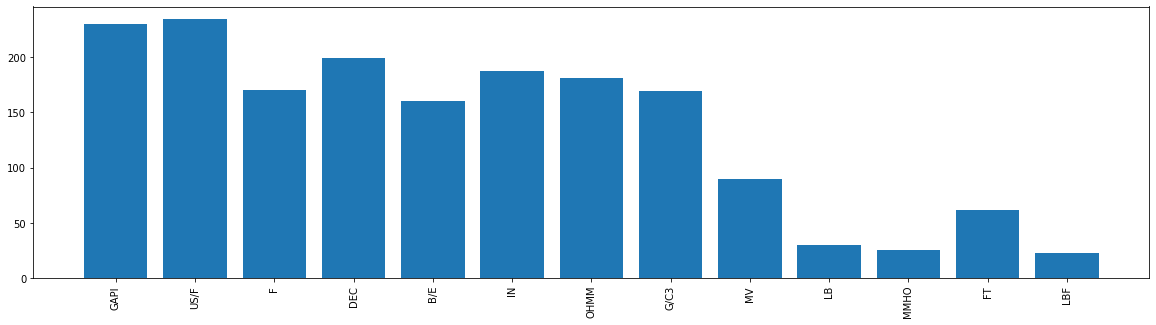

In [47]:
keys = []
for key in unitCount:
    if unitCount[key] > 10:
        keys.append(key)
values = [unitCount[key] for key in keys]
plt.figure(figsize=(20, 5))
plt.bar(keys, values)
plt.xticks(rotation=90)
plt.show()

Here we extract the actual log data from the las file.

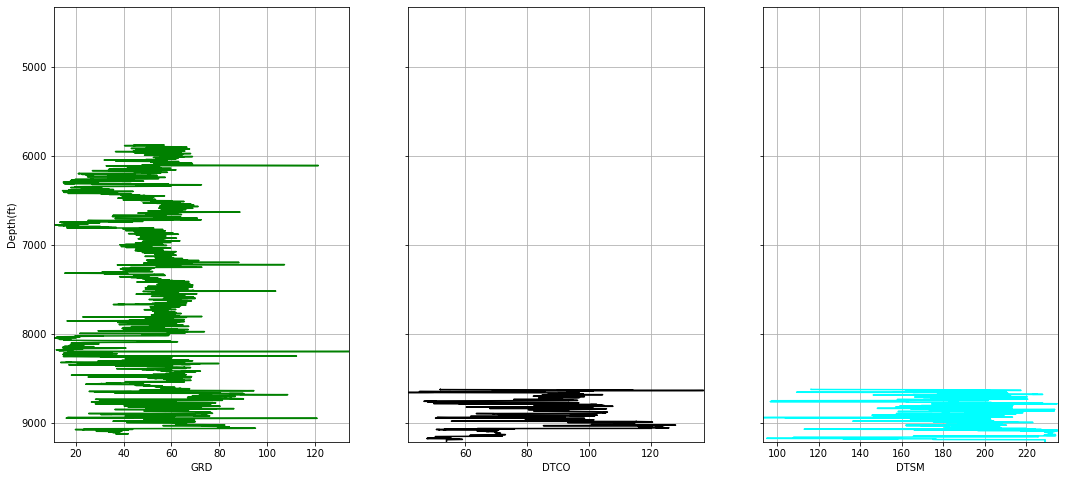

In [58]:
las = lasDic['cbe115c74a89_TGS.las']
logs = las.df()

f, ax = plt.subplots(1,3, figsize=(18,8), sharey=True)
ax[0].plot(logs['GRD'], logs.index, color='green')
ax[1].plot(logs['DTCO'], logs.index, color='black')
ax[2].plot(logs['DTSM'], logs.index, color='cyan')

for i in range(len(ax)):
    ax[i].set_ylim(logs.index[0], logs.index[-1])
    ax[i].invert_yaxis()
    ax[i].grid()
    
ax[0].set_xlabel('GRD')
ax[0].set_xlim(logs['GRD'].min(), logs['GRD'].max())
ax[0].set_ylabel('Depth(ft)')
ax[1].set_xlabel('DTCO')
ax[1].set_xlim(logs['DTCO'].min(), logs['DTCO'].max())
ax[2].set_xlabel('DTSM')
ax[2].set_xlim(logs['DTSM'].min(), logs['DTSM'].max());

We can map out how two particular mnmonics appears across all wells and across all depths. For example, we can select GRD and GRS and look to see at which wells and at what depth intervals, one of them, both of them, or none of them appear.

In [63]:
maxdepth = 25000
datamap = np.ndarray(shape=(maxdepth, len(lasDic)), dtype=int)
x1 = 'GRD'
x2 = 'GRS'
wellNo = 0
for filename in lasDic:
    print("on well: {}".format(filename))
    df = lasDic[filename].df()
    allmeasures = list(df.columns)
    for i in range(maxdepth):
        if i not in df.index:
            datamap[i,wellNo] = 0 #code for no data at all at that depth
            continue
        try:
            x1_val = df.loc[i, x1]
        except:
            x1_val = np.nan
        try:
            x2_val = df.loc[i, x2]
        except:
            x2_val = np.nan
            
        if np.isnan(x1_val) and np.isnan(x2_val):
            datamap[i,wellNo] = 1 #code for data available at the depth but not x1 or x2
        elif not np.isnan(x1_val) and  np.isnan(x2_val):
            datamap[i,wellNo] = 2 #code for only x1 available at that depth
        elif np.isnan(x1_val) and  not np.isnan(x2_val):
            datamap[i,wellNo] = 3 #code for only x2 available at that depth
        elif not np.isnan(x1_val) and  not np.isnan(x2_val):
            datamap[i,wellNo] = 4 #code for both x1 and x2 available at that depth
    wellNo += 1

on well: 0052442d0162_TGS.las
on well: 00a60e5cc262_TGS.las
on well: 01c726e0fabe_TGS.las
on well: 02571837c35f_TGS.las
on well: 03d4fc789db8_TGS.las
on well: 046bc790f386_TGS.las
on well: 0542bc36f0cb_TGS.las
on well: 069d09bef946_TGS.las
on well: 07bda346ac4d_TGS.las
on well: 095b70877102_TGS.las
on well: 09a9e11b83f4_TGS.las
on well: 0a65a72dd23f_TGS.las
on well: 0df16b6a5cc4_TGS.las
on well: 0e121cce5c23_TGS.las
on well: 0f3ce2a7dd98_TGS.las
on well: 0f7a4609731a_TGS.las
on well: 113ec23e6142_TGS.las
on well: 115b34035794_TGS.las
on well: 11e86c424d08_TGS.las
on well: 1332e8ac4af0_TGS.las
on well: 146b023afbcf_TGS.las
on well: 15560bf61021_TGS.las
on well: 16bb5ea9d2d3_TGS.las
on well: 1737d6c90d5e_TGS.las
on well: 19ed10214869_TGS.las
on well: 1a000e7f474b_TGS.las
on well: 1ad2434c11e7_TGS.las
on well: 1bff6afa48e2_TGS.las
on well: 1cf78b7ca1cc_TGS.las
on well: 1dab7ce73d3f_TGS.las
on well: 1f439d39052a_TGS.las
on well: 1f854180654f_TGS.las
on well: 1f901b2ab8a5_TGS.las
on well: 2

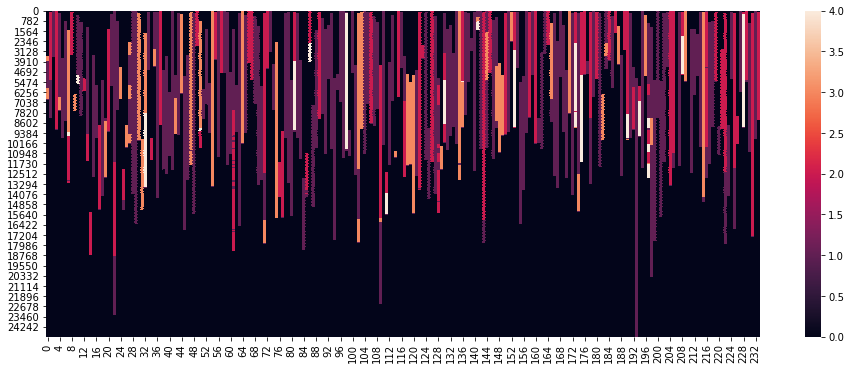

In [64]:
plt.figure(figsize=(16,6))
ax=sns.heatmap(datamap)

Here, we will go through all rows of all wells data and extract those that have both "GRD" and "GRS" listed for the same depth.

In [69]:
x1 = 'GRD'
x2 = 'GRS'
x1List = []
x2List = []
for filename in lasDic:
    allmeasures = list(lasDic[filename].df().columns)
    if x1 in allmeasures and x2 in allmeasures:
        for index, row in lasDic[filename].df().iterrows():
            x1_val = row[allmeasures.index(x1)]
            x2_val = row[allmeasures.index(x2)]
            if not isnan(x1_val) and not isnan(x2_val):
                x1List.append(x1_val)
                x2List.append(x2_val)

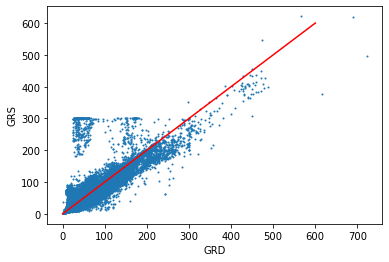

In [70]:
plt.scatter(x1List, x2List, s=1)
plt.xlabel(x1)
plt.ylabel(x2)
plt.plot([0,600],[0,600], c='r')
plt.show()

# Data Preparation

## Lat-Long Field Table

In [8]:
data = []
for filename in lasDic:
    las = lasDic[filename]
    datas = []
    datas.append(filename); datas.append(las.well['SLAT'].value); datas.append(las.well['SLON'].value)
    data.append(datas)
data = np.asarray(data)
wh_df = pd.DataFrame(data, columns=['WELL', 'LAT', 'LON'])

In [9]:
wh_df.head()

WELL                 LAT                LON
0  0052442d0162_TGS.las   1.678958417317098  6.390538637896995
1  00a60e5cc262_TGS.las  3.6806701293464954  7.095404039225997
2  01c726e0fabe_TGS.las   2.763907729221394   9.10495536851299
3  02571837c35f_TGS.las  2.2998730455597993     5.807630427682
4  03d4fc789db8_TGS.las  1.4047718878026991   8.61810387525999

In [10]:
wh_df['LAT'] = pd.to_numeric(wh_df['LAT'], downcast='float')
wh_df['LON'] = pd.to_numeric(wh_df['LON'], downcast='float')

In [11]:
wh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 3 columns):
WELL    234 non-null object
LAT     234 non-null float32
LON     234 non-null float32
dtypes: float32(2), object(1)
memory usage: 3.8+ KB


### K-Means Clustering

In [12]:
from sklearn.cluster import KMeans

In [13]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(wh_df.drop('WELL',axis=1))

KMeans(n_clusters=2)

In [14]:
wh_df['FIELD']=kmeans.labels_

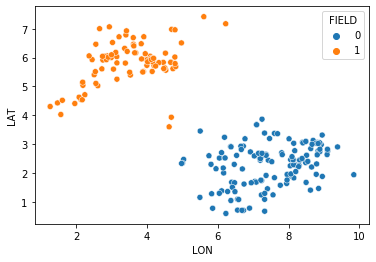

In [15]:
sns.scatterplot(x='LON',y='LAT',data=wh_df, hue='FIELD')

In [16]:
save_model(kmeans, "field_clustering.pkl")

Model is pickled as model/field_clustering.pkl


C:\Users\ANaufal\AppData\Local\Continuum\anaconda3\envs\jcopdl\lib\site-packages\jcopml\utils\_save_model.py:26: ResourceWarning: unclosed file <_io.BufferedWriter name='model/field_clustering.pkl'>
  pickle.dump(model, open(f"{folder_name}/{file_name}", "wb"))


In [17]:
wh_arr = np.array(wh_df)

# Feature Curve Model Generation 

## GRR Model

In [35]:
labels = ['DEPT', 'GRR']
data = []
for filename in tqdm(lasDic):
    allmeasures = list(lasDic[filename].df().reset_index().columns)
    wh_row = wh_arr[wh_arr[:,0] == filename][0]
    if all([item in allmeasures for item in labels]):
        for index, row in lasDic[filename].df().reset_index().iterrows():
            datas = []
            [datas.append(row[allmeasures.index(i)]) for i in labels]
            datas.append(wh_row[1]); datas.append(wh_row[2]);datas.append(wh_row[3])
            if all([not isnan(item) for item in datas]):
                data.append(datas)
data = np.asarray(data)
df = pd.DataFrame(data, columns=['DEPT', 'GRR', 'LAT', 'LON', 'FIELD'])

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1153660 entries, 0 to 1153659
Data columns (total 5 columns):
DEPT     1153660 non-null float64
GRR      1153660 non-null float64
LAT      1153660 non-null float64
LON      1153660 non-null float64
FIELD    1153660 non-null float64
dtypes: float64(5)
memory usage: 44.0 MB


### Train Test Split

In [45]:
X = df.drop(columns="GRR")
y = df['GRR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((922928, 4), (230732, 4), (922928,), (230732,))

### Training

In [50]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["DEPT", "LAT", "LON"]),
    ('categoric', cat_pipe(encoder='onehot'), ["FIELD"]),
])

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [52]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, scoring='neg_root_mean_squared_error', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo': RandomForestRegressor(max_depth=46, max_features=0.8153301731874837,
                      n_estimators=127, n_jobs=-1, random_state=42), 'algo__max_depth': 46, 'algo__max_features': 0.8153301731874837, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 127, 'prep__categoric': Pipeline(steps=[('imputer',
                 SimpleImputer(add_indicator=True, strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))]), 'prep__categoric__imputer__add_indicator': True, 'prep__numeric': Pipeline(steps=[('imputer', SimpleImputer(add_indicator=True)),
                ('transformer', PowerTransformer())]), 'prep__numeric__imputer__add_indicator': True}
-1.5714671597824859 -5.991212146410379 -4.198930164864132


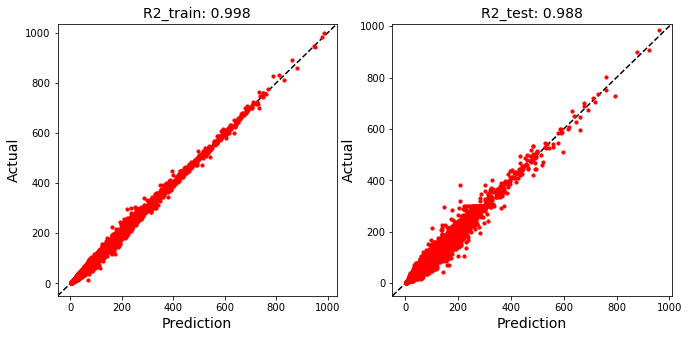

In [53]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

In [55]:
save_model(model.best_estimator_, "model_GRR.pkl")

Model is pickled as model/model_GRR.pkl


## PEF Model

In [83]:
labels = ['DEPT', 'PEF']
data = []
for filename in tqdm(lasDic):
    allmeasures = list(lasDic[filename].df().reset_index().columns)
    wh_row = wh_arr[wh_arr[:,0] == filename][0]
    if all([item in allmeasures for item in labels]):
        for index, row in lasDic[filename].df().reset_index().iterrows():
            datas = []
            [datas.append(row[allmeasures.index(i)]) for i in labels]
            datas.append(wh_row[1]); datas.append(wh_row[2]);datas.append(wh_row[3])
            if all([not isnan(item) for item in datas]):
                data.append(datas)
data = np.asarray(data)
df = pd.DataFrame(data, columns=['DEPT', 'PEF', 'LAT', 'LON', 'FIELD'])

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397771 entries, 0 to 397770
Data columns (total 5 columns):
DEPT     397771 non-null float64
PEF      397771 non-null float64
LAT      397771 non-null float64
LON      397771 non-null float64
FIELD    397771 non-null float64
dtypes: float64(5)
memory usage: 15.2 MB


### Train Test Split

In [85]:
X = df.drop(columns="PEF")
y = df['PEF']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((318216, 4), (79555, 4), (318216,), (79555,))

### Training

In [61]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["DEPT", "LAT", "LON"]),
    ('categoric', cat_pipe(encoder='onehot'), ["FIELD"]),
])

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [63]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, scoring='neg_root_mean_squared_error', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo': RandomForestRegressor(max_depth=46, max_features=0.8153301731874837,
                      n_estimators=127, n_jobs=-1, random_state=42), 'algo__max_depth': 46, 'algo__max_features': 0.8153301731874837, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 127, 'prep__categoric': Pipeline(steps=[('imputer',
                 SimpleImputer(add_indicator=True, strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))]), 'prep__categoric__imputer__add_indicator': True, 'prep__numeric': Pipeline(steps=[('imputer', SimpleImputer(add_indicator=True)),
                ('transformer', PowerTransformer())]), 'prep__numeric__imputer__add_indicator': True}
-0.06019401050348276 -0.2198542962904543 -0.16676355531597936


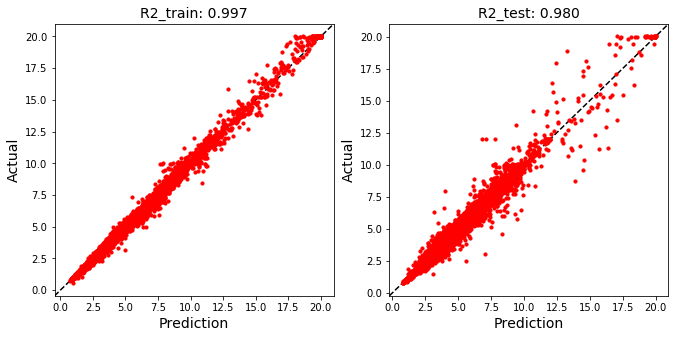

In [87]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

In [64]:
save_model(model.best_estimator_, "model_PEF.pkl")

Model is pickled as model/model_PEF.pkl


C:\Users\ANaufal\AppData\Local\Continuum\anaconda3\envs\jcopdl\lib\site-packages\jcopml\utils\_save_model.py:26: ResourceWarning: unclosed file <_io.BufferedWriter name='model/model_PEF.pkl'>
  pickle.dump(model, open(f"{folder_name}/{file_name}", "wb"))


## RHOB Model

In [66]:
labels = ['DEPT', 'RHOB']
data = []
for filename in tqdm(lasDic):
    allmeasures = list(lasDic[filename].df().reset_index().columns)
    wh_row = wh_arr[wh_arr[:,0] == filename][0]
    if all([item in allmeasures for item in labels]):
        for index, row in lasDic[filename].df().reset_index().iterrows():
            datas = []
            [datas.append(row[allmeasures.index(i)]) for i in labels]
            datas.append(wh_row[1]); datas.append(wh_row[2]);datas.append(wh_row[3])
            if all([not isnan(item) for item in datas]):
                data.append(datas)
data = np.asarray(data)
df = pd.DataFrame(data, columns=['DEPT', 'RHOB', 'LAT', 'LON', 'FIELD'])

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578800 entries, 0 to 578799
Data columns (total 5 columns):
DEPT     578800 non-null float64
RHOB     578800 non-null float64
LAT      578800 non-null float64
LON      578800 non-null float64
FIELD    578800 non-null float64
dtypes: float64(5)
memory usage: 22.1 MB


### Train Test Split

In [68]:
X = df.drop(columns="RHOB")
y = df['RHOB']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((463040, 4), (115760, 4), (463040,), (115760,))

### Training

In [69]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["DEPT", "LAT", "LON"]),
    ('categoric', cat_pipe(encoder='onehot'), ["FIELD"]),
])

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [71]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, scoring='neg_root_mean_squared_error', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo': RandomForestRegressor(max_depth=43, max_features=0.4640573144099711,
                      n_estimators=123, n_jobs=-1, random_state=42), 'algo__max_depth': 43, 'algo__max_features': 0.4640573144099711, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 123, 'prep__categoric': Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))]), 'prep__categoric__imputer__add_indicator': False, 'prep__numeric': Pipeline(steps=[('imputer', KNNImputer(add_indicator=True)),
                ('scaler', RobustScaler())]), 'prep__numeric__imputer__add_indicator': True}
-0.010563823198648311 -0.039162022149539254 -0.028820131721672845


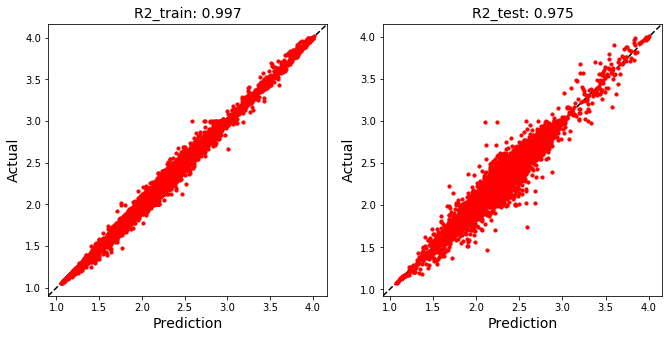

In [72]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

In [73]:
save_model(model.best_estimator_, "model_RHOB.pkl")

Model is pickled as model/model_RHOB.pkl


C:\Users\ANaufal\AppData\Local\Continuum\anaconda3\envs\jcopdl\lib\site-packages\jcopml\utils\_save_model.py:26: ResourceWarning: unclosed file <_io.BufferedWriter name='model/model_RHOB.pkl'>
  pickle.dump(model, open(f"{folder_name}/{file_name}", "wb"))


## SPR Model

In [74]:
labels = ['DEPT', 'SPR']
data = []
for filename in tqdm(lasDic):
    allmeasures = list(lasDic[filename].df().reset_index().columns)
    wh_row = wh_arr[wh_arr[:,0] == filename][0]
    if all([item in allmeasures for item in labels]):
        for index, row in lasDic[filename].df().reset_index().iterrows():
            datas = []
            [datas.append(row[allmeasures.index(i)]) for i in labels]
            datas.append(wh_row[1]); datas.append(wh_row[2]);datas.append(wh_row[3])
            if all([not isnan(item) for item in datas]):
                data.append(datas)
data = np.asarray(data)
df = pd.DataFrame(data, columns=['DEPT', 'SPR', 'LAT', 'LON', 'FIELD'])

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211684 entries, 0 to 1211683
Data columns (total 5 columns):
DEPT     1211684 non-null float64
SPR      1211684 non-null float64
LAT      1211684 non-null float64
LON      1211684 non-null float64
FIELD    1211684 non-null float64
dtypes: float64(5)
memory usage: 46.2 MB


### Train Test Split

In [76]:
X = df.drop(columns="SPR")
y = df['SPR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((969347, 4), (242337, 4), (969347,), (242337,))

### Training

In [77]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["DEPT", "LAT", "LON"]),
    ('categoric', cat_pipe(encoder='onehot'), ["FIELD"]),
])

In [78]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [79]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, scoring='neg_root_mean_squared_error', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo': RandomForestRegressor(max_depth=46, max_features=0.8153301731874837,
                      n_estimators=127, n_jobs=-1, random_state=42), 'algo__max_depth': 46, 'algo__max_features': 0.8153301731874837, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 127, 'prep__categoric': Pipeline(steps=[('imputer',
                 SimpleImputer(add_indicator=True, strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))]), 'prep__categoric__imputer__add_indicator': True, 'prep__numeric': Pipeline(steps=[('imputer', SimpleImputer(add_indicator=True)),
                ('transformer', PowerTransformer())]), 'prep__numeric__imputer__add_indicator': True}
-0.3868606659762237 -1.420687461859849 -1.030932466635662


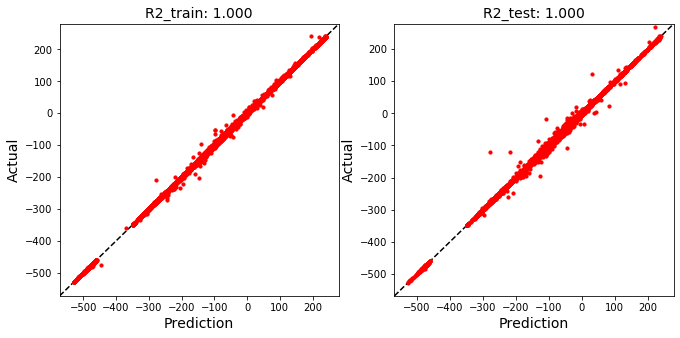

In [80]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

In [81]:
save_model(model.best_estimator_, "model_SPR.pkl")

Model is pickled as model/model_SPR.pkl


C:\Users\ANaufal\AppData\Local\Continuum\anaconda3\envs\jcopdl\lib\site-packages\jcopml\utils\_save_model.py:26: ResourceWarning: unclosed file <_io.BufferedWriter name='model/model_SPR.pkl'>
  pickle.dump(model, open(f"{folder_name}/{file_name}", "wb"))


## NPHI Model

In [107]:
labels = ['DEPT', 'NPHI']
data = []
for filename in tqdm(lasDic):
    allmeasures = list(lasDic[filename].df().reset_index().columns)
    wh_row = wh_arr[wh_arr[:,0] == filename][0]
    if all([item in allmeasures for item in labels]):
        for index, row in lasDic[filename].df().reset_index().iterrows():
            datas = []
            [datas.append(row[allmeasures.index(i)]) for i in labels]
            datas.append(wh_row[1]); datas.append(wh_row[2]);datas.append(wh_row[3])
            if all([not isnan(item) for item in datas]):
                data.append(datas)
data = np.asarray(data)
df = pd.DataFrame(data, columns=['DEPT', 'NPHI', 'LAT', 'LON', 'FIELD'])

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435327 entries, 0 to 435326
Data columns (total 5 columns):
DEPT     435327 non-null float64
NPHI     435327 non-null float64
LAT      435327 non-null float64
LON      435327 non-null float64
FIELD    435327 non-null float64
dtypes: float64(5)
memory usage: 16.6 MB


### Train Test Split

In [109]:
X = df.drop(columns="NPHI")
y = df['NPHI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((348261, 4), (87066, 4), (348261,), (87066,))

### Training

In [110]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["DEPT", "LAT", "LON"]),
    ('categoric', cat_pipe(encoder='onehot'), ["FIELD"]),
])

In [111]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [112]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, scoring='neg_root_mean_squared_error', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo': RandomForestRegressor(max_depth=43, max_features=0.4640573144099711,
                      n_estimators=123, n_jobs=-1, random_state=42), 'algo__max_depth': 43, 'algo__max_features': 0.4640573144099711, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 123, 'prep__categoric': Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))]), 'prep__categoric__imputer__add_indicator': False, 'prep__numeric': Pipeline(steps=[('imputer', KNNImputer(add_indicator=True)),
                ('scaler', RobustScaler())]), 'prep__numeric__imputer__add_indicator': True}
-0.005112348973730187 -0.019189707012118855 -0.013737063880627594


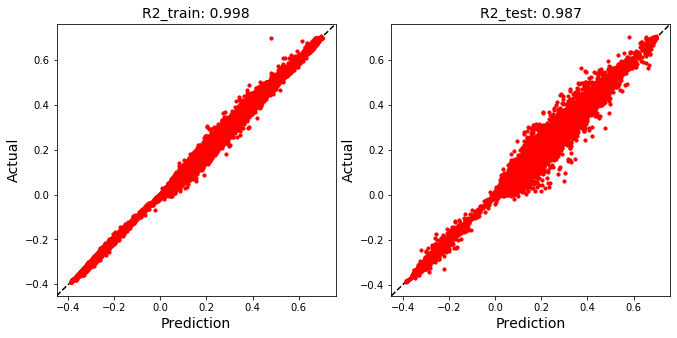

In [113]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

In [114]:
save_model(model.best_estimator_, "model_NPHI.pkl")

Model is pickled as model/model_NPHI.pkl


C:\Users\ANaufal\AppData\Local\Continuum\anaconda3\envs\jcopdl\lib\site-packages\jcopml\utils\_save_model.py:26: ResourceWarning: unclosed file <_io.BufferedWriter name='model/model_NPHI.pkl'>
  pickle.dump(model, open(f"{folder_name}/{file_name}", "wb"))


## CALD Model

In [28]:
labels = ['DEPT', 'CALD']
data = []
for filename in tqdm(lasDic):
    allmeasures = list(lasDic[filename].df().reset_index().columns)
    wh_row = wh_arr[wh_arr[:,0] == filename][0]
    if all([item in allmeasures for item in labels]):
        for index, row in lasDic[filename].df().reset_index().iterrows():
            datas = []
            [datas.append(row[allmeasures.index(i)]) for i in labels]
            datas.append(wh_row[1]); datas.append(wh_row[2]);datas.append(wh_row[3])
            if all([not isnan(item) for item in datas]):
                data.append(datas)
data = np.asarray(data)
df = pd.DataFrame(data, columns=['DEPT', 'CALD', 'LAT', 'LON', 'FIELD'])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925363 entries, 0 to 925362
Data columns (total 5 columns):
DEPT     925363 non-null float64
CALD     925363 non-null float64
LAT      925363 non-null float64
LON      925363 non-null float64
FIELD    925363 non-null float64
dtypes: float64(5)
memory usage: 35.3 MB


### Train Test Split

In [30]:
X = df.drop(columns="CALD")
y = df['CALD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((740290, 4), (185073, 4), (740290,), (185073,))

### Training

In [31]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ["DEPT", "LAT", "LON"]),
    ('categoric', cat_pipe(encoder='onehot'), ["FIELD"]),
])

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [33]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_poly_params, cv=3, scoring='neg_root_mean_squared_error', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 35, 'algo__max_features': 0.9073992339573195, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 123, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': True}
-0.0708447931762211 -0.23908738329294366 -0.1860851524671283


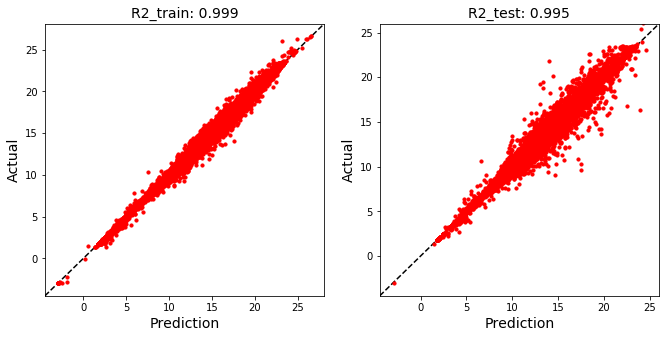

In [34]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

In [35]:
save_model(model.best_estimator_, "model_CALD.pkl")

Model is pickled as model/model_CALD.pkl


C:\Users\ANaufal\AppData\Local\Continuum\anaconda3\envs\jcopdl\lib\site-packages\jcopml\utils\_save_model.py:26: ResourceWarning: unclosed file <_io.BufferedWriter name='model/model_CALD.pkl'>
  pickle.dump(model, open(f"{folder_name}/{file_name}", "wb"))


# DTSM Model

In [18]:
curveCount = {}
for filename in lasDic:
    las = lasDic[filename]
    for item in las.curves.iteritems():
        if item[0] in curveCount.keys():
            curveCount[item[0]] += 1
        else:
            curveCount[item[0]] = 1

In [19]:
keys = []
for key in curveCount:
    if curveCount[key] > 10:
        keys.append(key)
values = [curveCount[key] for key in keys]
df_values = pd.DataFrame({'Mneumonic': keys, 'Count': values})
df_values = df_values[df_values['Mneumonic'] != 'DEPT'].sort_values('Count', ascending=False).reset_index(drop=True).head(20)
df_values

Mneumonic  Count
0       DTSM    234
1       DTCO    223
2       PEFZ    104
3       CALD     92
4       HDRA     91
5        SPR     89
6       RHOZ     87
7    DPHZ_LS     79
8    TNPH_LS     77
9        GRD     75
10       GRR     74
11      RHOB     73
12      DRHO     69
13       GRS     60
14       PEF     54
15      RLA5     50
16      NPHI     50
17      AT30     48
18   NPHI_LS     47
19      RLA3     44

In [20]:
labels = ['GRR', 'PEF', 'NPHI', 'DTCO', 'SPR', 'RHOB', 'DTSM', 'CALD']
count = 0
for filename in tqdm(lasDic):
    allmeasures = list(lasDic[filename].df().columns)
    if all([item in allmeasures for item in labels]):
        count += 1
        
count

14

In [21]:
labels = ['GRR', 'PEF', 'NPHI', 'DTCO', 'SPR', 'RHOB', 'DTSM', 'CALD']
data = []
for filename in tqdm(lasDic):
    allmeasures = list(lasDic[filename].df().reset_index().columns)
    wh_row = wh_arr[wh_arr[:,0] == filename][0]
    if all([item in allmeasures for item in labels]):
        for index, row in lasDic[filename].df().reset_index().iterrows():
            datas = []
            [datas.append(row[allmeasures.index(i)]) for i in labels]
            datas.append(wh_row[1]); datas.append(wh_row[2]);datas.append(wh_row[3])
            if all([not isnan(item) for item in datas]):
                data.append(datas)
data = np.asarray(data)
df = pd.DataFrame(data, columns=['GRR', 'PEF', 'NPHI', 'DTCO', 'SPR', 'RHOB', 'DTSM', 'CALD', 'LAT', 'LON', 'FIELD'])

missing_value    %
GRR                0  0.0
PEF                0  0.0
NPHI               0  0.0
DTCO               0  0.0
SPR                0  0.0
RHOB               0  0.0
DTSM               0  0.0
CALD               0  0.0
LAT                0  0.0
LON                0  0.0
FIELD              0  0.0

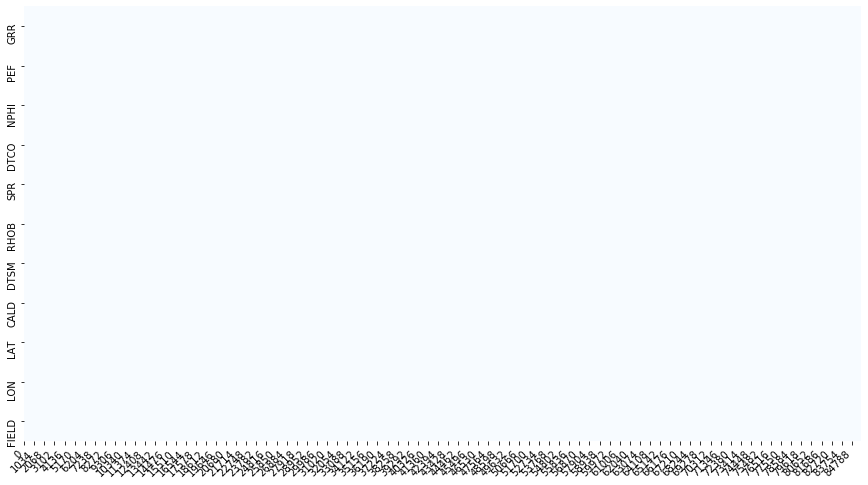

In [22]:
plot_missing_value(df, return_df=True)

# Baseline Model - AutoML

In [23]:
from jcopml.automl import AutoRegressor

In [24]:
X = df.drop(columns="DTSM")
y = df['DTSM']

## Training

In [25]:
model = AutoRegressor(X.columns,[])

In [26]:
model.fit(X,y,cv=5)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
================== Best Model Info ==================
algo                      | RandomForestRegressor
algo__max_depth           | 47
algo__max_features        | 0.7020316536967898
algo__min_samples_leaf    | 1
algo__n_estimators        | 168

================================ Best Preprocessor Info =================================
categorical_imputer       | SimpleImputer(add_indicator=False, strategy='most_frequent')
categorical_encoder       | OneHotEncoder
num_imputer               | SimpleImputer(add_indicator=False, strategy='mean')
numerical_scaler          | RobustScaler

=========== Score ===========
Train: 0.9928099916974699
Valid: 0.9481542510814822
Test : 0.9531014611919968


## View Results

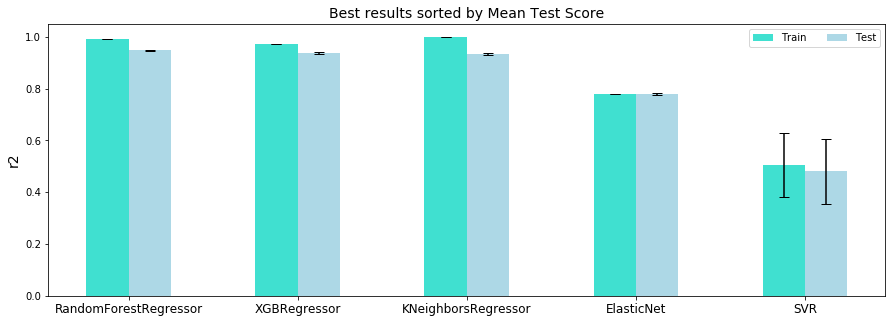

In [27]:
model.plot_results()

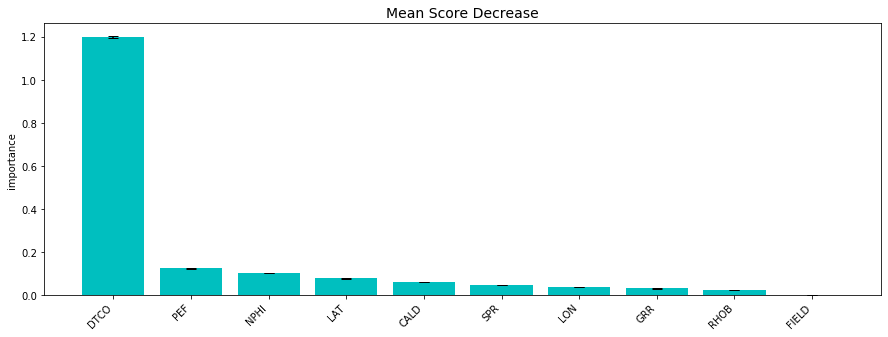

In [28]:
model.mean_score_decrease()

## Correlation Plot

In [29]:
from jcopml.plot import plot_correlation_matrix

In [30]:
plot_correlation_matrix(df, 'DTSM', numeric_col='auto')

interactive(children=(ToggleButtons(description='method', options=('spearman', 'kendall', 'pearson', 'pearson_…

# Final Model- RF

## Dataset Splitting

In [31]:
X = df.drop(columns="DTSM")
y = df['DTSM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((68598, 10), (17150, 10), (68598,), (17150,))

## Training

In [32]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), X.columns),
])

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [34]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_poly_params, cv=5, scoring='neg_root_mean_squared_error', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'algo__max_depth': 21, 'algo__max_features': 0.26364247048639056, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 175, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': False}
-2.321036680137365 -5.877129533222523 -5.634140609579337


In [39]:
from sklearn.metrics import r2_score
r2_score(y_test, model.predict(X_test))

0.9535539775339963

## Plotting

In [40]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual

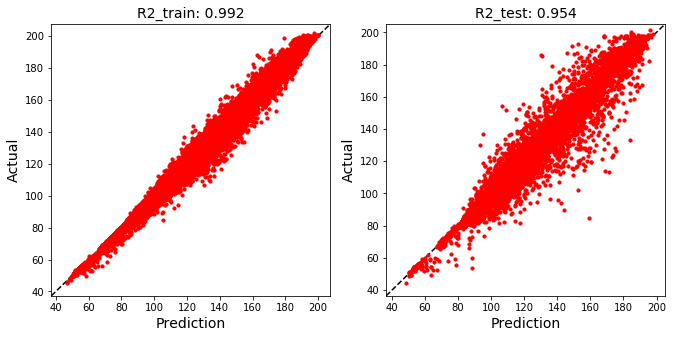

In [41]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

C:\Users\ANaufal\AppData\Local\Continuum\anaconda3\envs\jcopdl\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\ANaufal\AppData\Local\Continuum\anaconda3\envs\jcopdl\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


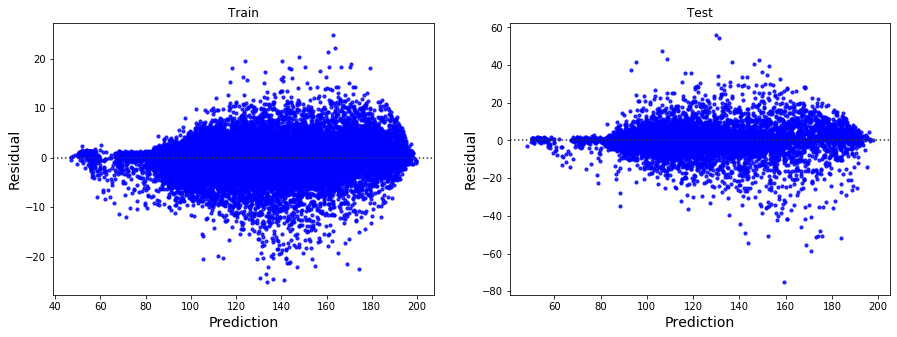

In [42]:
plot_residual(X_train, y_train, X_test, y_test, model)

In [43]:
save_model(model.best_estimator_, "RF_Best.pkl")

Model is pickled as model/RF_Best.pkl


C:\Users\ANaufal\AppData\Local\Continuum\anaconda3\envs\jcopdl\lib\site-packages\jcopml\utils\_save_model.py:26: ResourceWarning: unclosed file <_io.BufferedWriter name='model/RF_Best.pkl'>
  pickle.dump(model, open(f"{folder_name}/{file_name}", "wb"))


## Well Check

In [6]:
model = load_model('model/RF_Best.pkl')

/Users/hpratama/opt/miniconda3/envs/jcopml/lib/python3.7/site-packages/jcopml/utils/_load_model.py:17: ResourceWarning: unclosed file <_io.BufferedReader name='model/RF_Best.pkl'>
  model = pickle.load(open(model_path, "rb"))


In [45]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [46]:
labels = ['GRR', 'PEF', 'NPHI', 'DTCO', 'SPR', 'RHOB', 'DTSM', 'CALD']
well_list = []
for filename in tqdm(lasDic):
    allmeasures = list(lasDic[filename].df().columns)
    if all([item in allmeasures for item in labels]):
        well_list.append(filename)
        
well_list

['0a65a72dd23f_TGS.las',
 '1cf78b7ca1cc_TGS.las',
 '27eedabb7f1b_TGS.las',
 '389595b964b6_TGS.las',
 '3ae75d54eac9_TGS.las',
 '4503ff73396f_TGS.las',
 '53b73a130d0c_TGS.las',
 '70a049901d0c_TGS.las',
 '714bd04772d7_TGS.las',
 '7b5c7cb115b4_TGS.las',
 '8b39e194343c_TGS.las',
 '9971672f4246_TGS.las',
 'c95d65c35ad9_TGS.las',
 'de80b6e3d82b_TGS.las']

In [ ]:
labels = ['GRR', 'PEF', 'NPHI', 'DTCO', 'SPR', 'RHOB', 'DTSM', 'CALD']
data = []
for filename in tqdm(lasDic):
    allmeasures = list(lasDic[filename].df().reset_index().columns)
    wh_row = wh_arr[wh_arr[:,0] == filename][0]
    if all([item in allmeasures for item in labels]):
        for index, row in lasDic[filename].df().reset_index().iterrows():
            datas = []
            [datas.append(row[allmeasures.index(i)]) for i in labels]
            datas.append(wh_row[1]); datas.append(wh_row[2]);datas.append(wh_row[3])
            if all([not isnan(item) for item in datas]):
                data.append(datas)
data = np.asarray(data)
df = pd.DataFrame(data, columns=['GRR', 'PEF', 'NPHI', 'DTCO', 'SPR', 'RHOB', 'DTSM', 'CALD', 'LAT', 'LON', 'FIELD'])

In [48]:
def plot_log(las_name):
    data = []
    labels = ['GRR', 'PEF', 'NPHI', 'DTCO', 'SPR', 'RHOB', 'DTSM', 'CALD']
    allmeasures = list(lasDic[las_name].df().columns)
    wh_row = wh_arr[wh_arr[:,0] == las_name][0]
    for index, row in tqdm(lasDic[las_name].df().iterrows(),desc="Row Scan"):
        datas = []
        [datas.append(row[allmeasures.index(i)]) for i in labels]
        datas.append(wh_row[1]); datas.append(wh_row[2]);datas.append(wh_row[3])
        if all([not isnan(item) for item in datas]):
            data.append(datas)
    data = np.asarray(data)
    try:
        df = pd.DataFrame(data, columns =['GRR', 'PEF', 'NPHI', 'DTCO', 'SPR', 'RHOB', 'DTSM', 'CALD', 'LAT', 'LON', 'FIELD'])
    except ValueError:
        print(f"No rows available for file: {las_name}")
        return
    
    X = df.drop(columns="DTSM")
    y = df.DTSM
    df['PRED'] = model.predict(X)

    fig,ax = plt.subplots(nrows=1, ncols=8, figsize=(15,12), sharey=True)
    for axes in ax:
        axes.invert_yaxis()
        axes.get_xaxis().set_visible(False)

        ax1 = ax[0].twiny()
        ax1.plot(df['GRR'], df.index, color='green')
        ax1.set_xlabel('GRR[API]', color='green')
        ax1.grid(True)
        ax1.tick_params(axis='x', colors='green')
        ax2 = ax[1].twiny()
        ax2.plot(df['DTCO'], df.index, color='blue')
        ax2.set_xlabel('DTCO[US/F]', color='blue')
        ax2.grid(True)
        ax2.tick_params(axis='x', colors='blue')
        ax3 = ax[2].twiny()
        ax3.plot(df['SPR'], df.index, color='yellow')
        ax3.set_xlabel('SPR[MV]', color='yellow')
        ax3.tick_params(axis='x', colors='yellow')
        ax3.grid(True)
        ax4 = ax[3].twiny()
        ax4.plot(df['RHOB'], df.index, color='magenta')
        ax4.set_xlabel('RHOB[G/C3]', color='magenta')
        ax4.tick_params(axis='x', colors='magenta')
        ax4.grid(True)
        ax5 = ax[4].twiny()
        ax5.plot(df['PEF'], df.index, color='coral')
        ax5.set_xlabel('PEF[B/E]', color='coral')
        ax5.tick_params(axis='x', colors='coral')
        ax5.grid(True)
        ax6 = ax[5].twiny()
        ax6.plot(df['NPHI'], df.index, color='cyan')
        ax6.set_xlabel('NPHI[DEC]', color='cyan')
        ax6.tick_params(axis='x', colors='cyan')
        ax6.grid(True)
        ax7 = ax[6].twiny()
        ax7.plot(df['CALD'], df.index, color='grey')
        ax7.set_xlabel('CALD[in]', color='grey')
        ax7.tick_params(axis='x', colors='grey')
        ax7.grid(True)
        ax8 = ax[7].twiny()
        ax8.plot(df['DTSM'], df.index, color='black')
        ax8.spines['top'].set_position(('outward',0))
        ax8.set_xlabel('DTSM[US/F]', color='black')
        ax8.tick_params(axis='x', colors='black')
        ax8.grid(True)
        ax9 = ax[7].twiny()
        ax9.plot(df['PRED'], df.index, color='red')
        ax9.spines['top'].set_position(('outward',40))
        ax9.set_xlabel('DTSM(PRED)', color='red')
        ax9.tick_params(axis='x', colors='red')
        ax9.grid(True)
    fig.suptitle('Well: %s'%las_name, fontweight='bold', fontsize=15, y=0.99);

interact(plot_log, las_name=well_list)

interactive(children=(Dropdown(description='las_name', options=('0a65a72dd23f_TGS.las', '1cf78b7ca1cc_TGS.las'…

<function __main__.plot_log(las_name)>

# Scoring

## Missing Log and Rows Feature Generation

### Read .las Files

In [49]:
os.getcwd()

'C:\\Users\\ANaufal\\OneDrive - Schlumberger\\Documents\\Schlumberger SIS\\Errands\\Publications\\SPE GCS ML Challenge\\ML Challenge Data'

In [50]:
lasDic = {}
for filename in tqdm(os.listdir(os.getcwd() + '\\Final LB'), desc='.las File'):
    if filename.endswith(".las"):
        lasDic[filename] = lasio.read('Final LB\\' + filename)

In [51]:
#check file versions
for filename in lasDic:
    las = lasDic[filename]
    print(las.version)

Mnemonic  Unit  Value  Description                           
--------  ----  -----  -----------                           
VERS            2.0    CWLS log ASCII Standard -VERSION 2.0  
WRAP            NO     One line per depth step               
DLM             SPACE  Column Data Section Delimiter         
Mnemonic  Unit  Value  Description                           
--------  ----  -----  -----------                           
VERS            2.0    CWLS log ASCII Standard -VERSION 2.0  
WRAP            NO     One line per depth step               
DLM             SPACE  Column Data Section Delimiter         
Mnemonic  Unit  Value  Description                           
--------  ----  -----  -----------                           
VERS            2.0    CWLS log ASCII Standard -VERSION 2.0  
WRAP            NO     One line per depth step               
DLM             SPACE  Column Data Section Delimiter         
Mnemonic  Unit  Value  Description                           
--------

### Lat-Long Field Table

In [52]:
data = []
for filename in lasDic:
    las = lasDic[filename]
    datas = []
    datas.append(filename); datas.append(las.well['SLAT'].value); datas.append(las.well['SLON'].value)
    data.append(datas)
data = np.asarray(data)
wh_df = pd.DataFrame(data, columns=['WELL', 'LAT', 'LON'])

In [53]:
wh_df.head()

WELL                 LAT                 LON
0  00d02be79f49_TGS.las   6.041329857338205  3.1554305884878033
1  0a7822c59487_TGS.las   0.673955273699999   7.358266710308001
2  113412eec2a6_TGS.las   5.522045610825501   2.485058810265926
3  1684cc35f399_TGS.las  3.9414597387125028   1.275738428261306
4  20372701d5e2_TGS.las  5.7030075122443975  3.2528639618739135

In [54]:
wh_df['LAT'] = pd.to_numeric(wh_df['LAT'], downcast='float')
wh_df['LON'] = pd.to_numeric(wh_df['LON'], downcast='float')

In [55]:
wh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
WELL    20 non-null object
LAT     20 non-null float32
LON     20 non-null float32
dtypes: float32(2), object(1)
memory usage: 448.0+ bytes


In [56]:
kmeans = load_model('model/field_clustering.pkl')
wh_df['FIELD'] = kmeans.predict(wh_df.drop('WELL',axis=1))

C:\Users\ANaufal\AppData\Local\Continuum\anaconda3\envs\jcopdl\lib\site-packages\jcopml\utils\_load_model.py:17: ResourceWarning: unclosed file <_io.BufferedReader name='model/field_clustering.pkl'>
  model = pickle.load(open(model_path, "rb"))


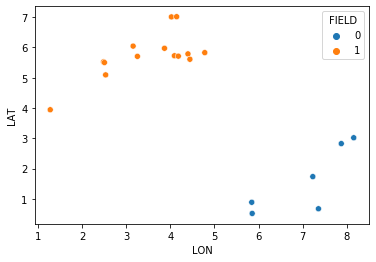

In [57]:
sns.scatterplot(x='LON',y='LAT',data=wh_df, hue='FIELD')

In [58]:
wh_arr = np.array(wh_df)

### Model Load

In [ ]:
grr_model = load_model('model/model_GRR.pkl')
pef_model = load_model('model/model_PEF.pkl')
rhob_model = load_model('model/model_RHOB.pkl')
nphi_model = load_model('model/model_NPHI.pkl')
spr_model = load_model('model/model_SPR.pkl')
cald_model = load_model('model/model_CALD.pkl')

In [ ]:
model_dict = {
    'GRR': grr_model,
    'PEF': pef_model,
    'RHOB': rhob_model,
    'NPHI': nphi_model,
    'SPR': spr_model,
    'CALD': cald_model
}

### Missing Logs and Rows Generation

In [ ]:
labels = ['GRR', 'DTCO', 'SPR', 'RHOB', 'PEF', 'NPHI', 'CALD']
for filename in lasDic:
    data = []
    allmeasures = list(lasDic[filename].df().reset_index().columns)
    wh_row = wh_arr[wh_arr[:,0] == filename][0]
    
    for index, row in tqdm(lasDic[filename].df().reset_index().iterrows(), desc=filename):
        X, datas = [], []
        X.append(row['DEPT']); X.append(wh_row[1]); X.append(wh_row[2]); X.append(wh_row[3])
        datas.append(filename); datas.append(wh_row[1]); datas.append(wh_row[2]); datas.append(wh_row[3])
        for i in labels:
            if i not in row.index:
                datas.append(model_dict[i].predict(pd.DataFrame([X],columns=['DEPT', 'LAT', 'LON', 'FIELD']))[0])
            elif i == 'DTCO':
                datas.append(row[i])
            elif isnan(row[i]):
                datas.append(model_dict[i].predict(pd.DataFrame([X],columns=['DEPT', 'LAT', 'LON', 'FIELD']))[0])
            else:
                datas.append(row[i])
        data.append(datas)    
    data = np.asarray(data)
    df = pd.DataFrame(data, columns=['WELL', 'LAT', 'LON', 'FIELD', 'GRR', 'DTCO', 'SPR', 'RHOB', 'PEF', 'NPHI', 'CALD'])
    df.to_csv(f'{filename}_rev.csv')

### Scoring 

In [7]:
def predict(wellname):
    #Import las and csv file
    df = pd.read_csv('FinalCSV/%s.las_rev.csv'%wellname)
    excel = pd.read_excel('Samsan-Tech/Leaderboard/%s.xlsx'%wellname, engine='openpyxl')
    #Get depth data
    DEPT = excel.Depth
    #Prepare Input data
    X = pd.DataFrame()
    X['GRR'] = df.GRR
    X['DTCO'] = df.DTCO
    X['SPR'] = df.SPR
    X['RHOB'] = df.RHOB
    X['PEF'] = df.PEF
    X['CALD'] = df.CALD
    X['NPHI'] = df.NPHI
    X['LAT'] = df.LAT
    X['LON'] = df.LON
    X['FIELD'] = df.FIELD
    #Predict Output
    X['DTSM'] = model.predict(X)
    #Submission file
    excel['DTSM'] = X.DTSM
    excel.to_excel('Samsan-Tech/Leaderboard/%s.xlsx'%wellname, index=False)
    #Plotting
    fig,ax = plt.subplots(nrows=1, ncols=8, figsize=(15,12), sharey=True)
    #GRR Curve
    ax1 = ax[0].twiny()
    ax1.plot(X['GRR'], DEPT, color='green')
    ax1.set_xlabel('GRR[API]', color='green')
    ax1.grid(True)
    ax1.tick_params(axis='x', colors='green')
    ax1.invert_yaxis()
    #DTCO Curve
    ax2 = ax[1].twiny()
    ax2.plot(X['DTCO'], DEPT, color='blue')
    ax2.set_xlabel('DTCO[US/F]', color='blue')
    ax2.grid(True)
    ax2.tick_params(axis='x', colors='blue')
    #SPR Curve
    ax3 = ax[2].twiny()
    ax3.plot(X['SPR'], DEPT, color='black')
    ax3.set_xlabel('SPR[MV]', color='black')
    ax3.tick_params(axis='x', colors='black')
    ax3.grid(True)
    #RHOB Curve
    ax4 = ax[3].twiny()
    ax4.plot(X['RHOB'], DEPT, color='cyan')
    ax4.set_xlabel('RHOB[G/C3]', color='cyan')
    ax4.tick_params(axis='x', colors='cyan')
    ax4.grid(True)
    #PEF Curve
    ax5 = ax[4].twiny()
    ax5.plot(X['PEF'], DEPT, color='coral')
    ax5.set_xlabel('PEF[B/E]', color='coral')
    ax5.tick_params(axis='x', colors='coral')
    ax5.grid(True)
    #CALD Curve
    ax6 = ax[5].twiny()
    ax6.plot(X['CALD'], DEPT, color='gold')
    ax6.set_xlabel('CALD', color='gold')
    ax6.tick_params(axis='x', colors='gold')
    ax6.grid(True)
    #NPHI Curve
    ax7 = ax[6].twiny()
    ax7.plot(X['NPHI'], DEPT, color='magenta')
    ax7.set_xlabel('NPHI', color='magenta')
    ax7.tick_params(axis='x', colors='magenta')
    ax7.grid(True)
    #DTSM Curve
    ax8 = ax[7].twiny()
    ax8.plot(X['DTSM'], DEPT, color='red')
    ax8.set_xlabel('DTSM(X)', color='red')
    ax8.tick_params(axis='x', colors='red')
    ax8.grid(True)
    fig.suptitle(wellname, fontweight='bold', fontsize=15, y=0.99)
    plt.show()

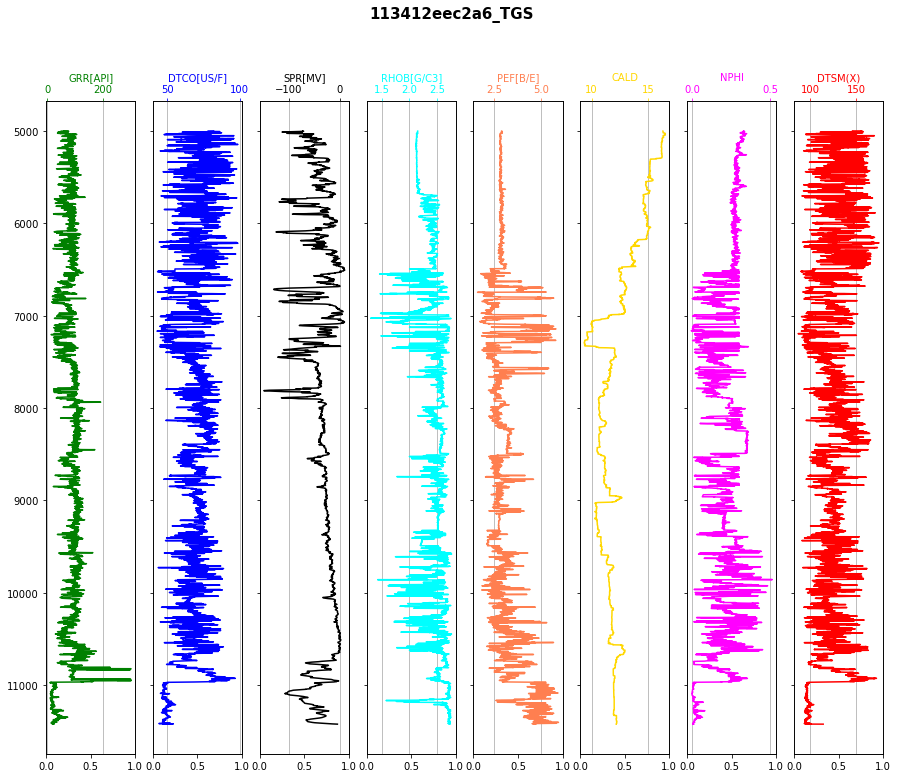

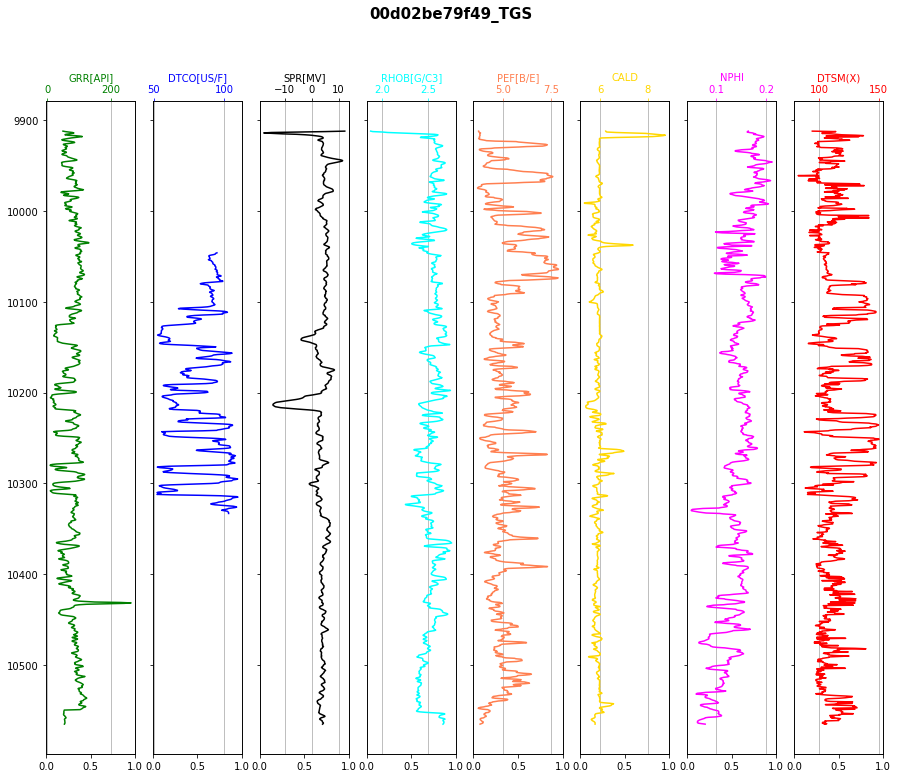

/Users/hpratama/opt/miniconda3/envs/jcopml/lib/python3.7/site-packages/openpyxl/cell/cell.py:109: ResourceWarning: unclosed file <_io.BufferedReader name='Samsan-Tech/Leaderboard/2f96a5f92418_TGS.xlsx'>
  super(Cell, self).__init__(worksheet, style_array)


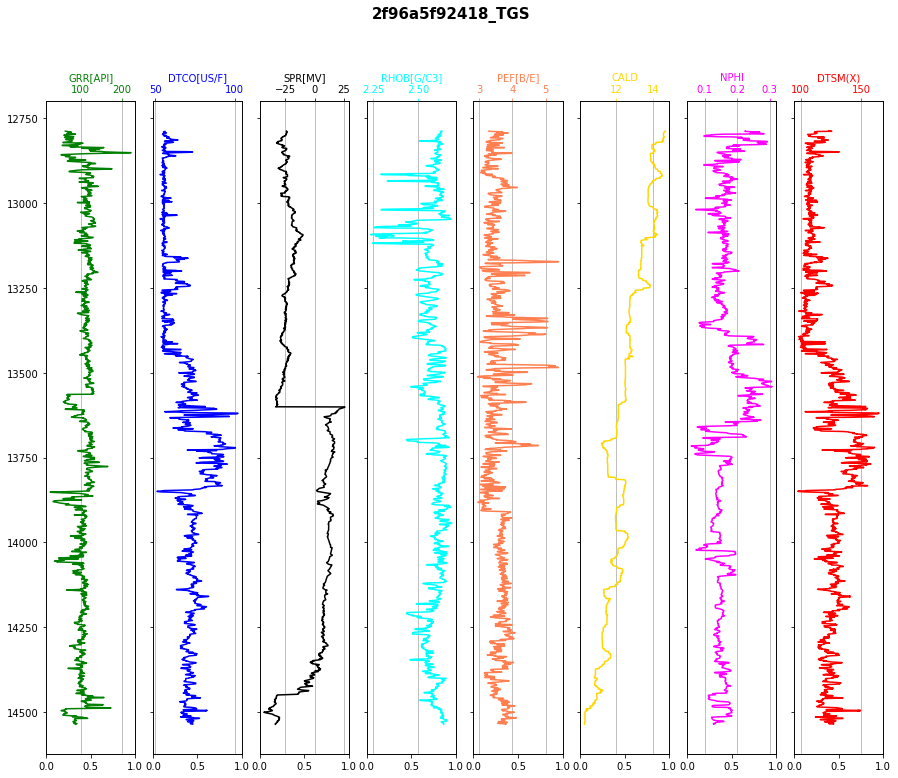

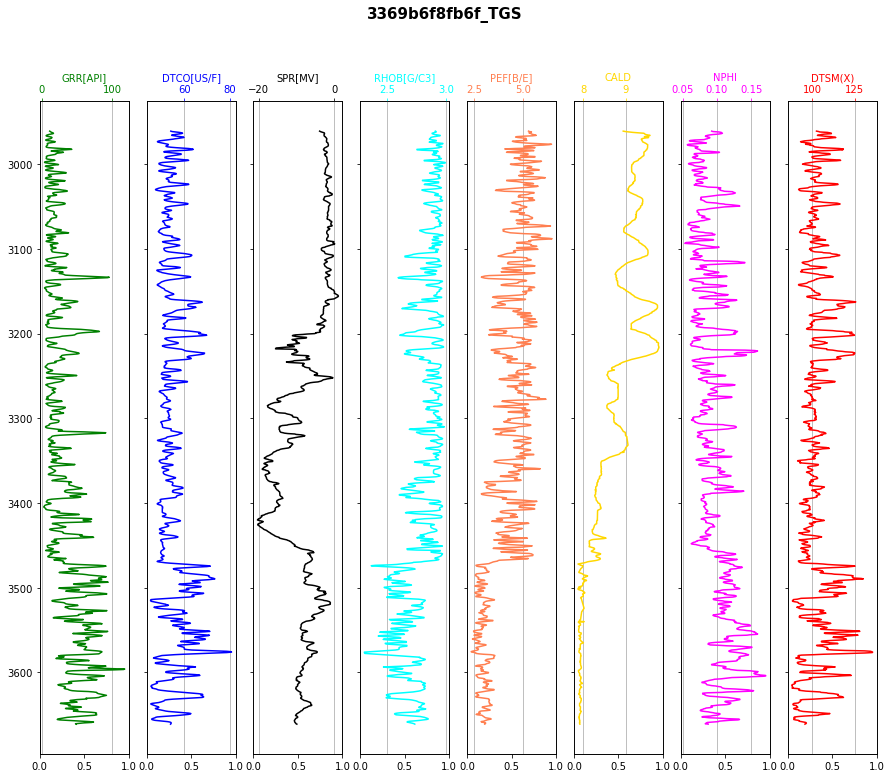

/Users/hpratama/opt/miniconda3/envs/jcopml/lib/python3.7/site-packages/openpyxl/cell/cell.py:109: ResourceWarning: unclosed file <_io.BufferedReader name='Samsan-Tech/Leaderboard/94c1f5cae85c_TGS.xlsx'>
  super(Cell, self).__init__(worksheet, style_array)


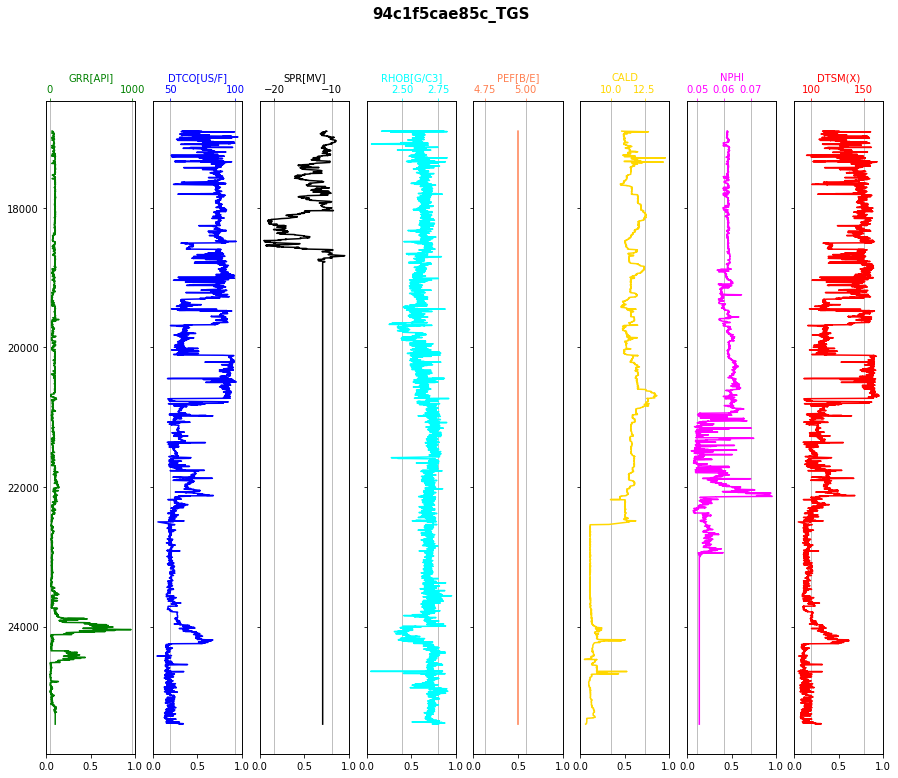

/Users/hpratama/opt/miniconda3/envs/jcopml/lib/python3.7/contextlib.py:82: ResourceWarning: unclosed file <_io.BufferedReader name='Samsan-Tech/Leaderboard/20372701d5e2_TGS.xlsx'>
  self.gen = func(*args, **kwds)


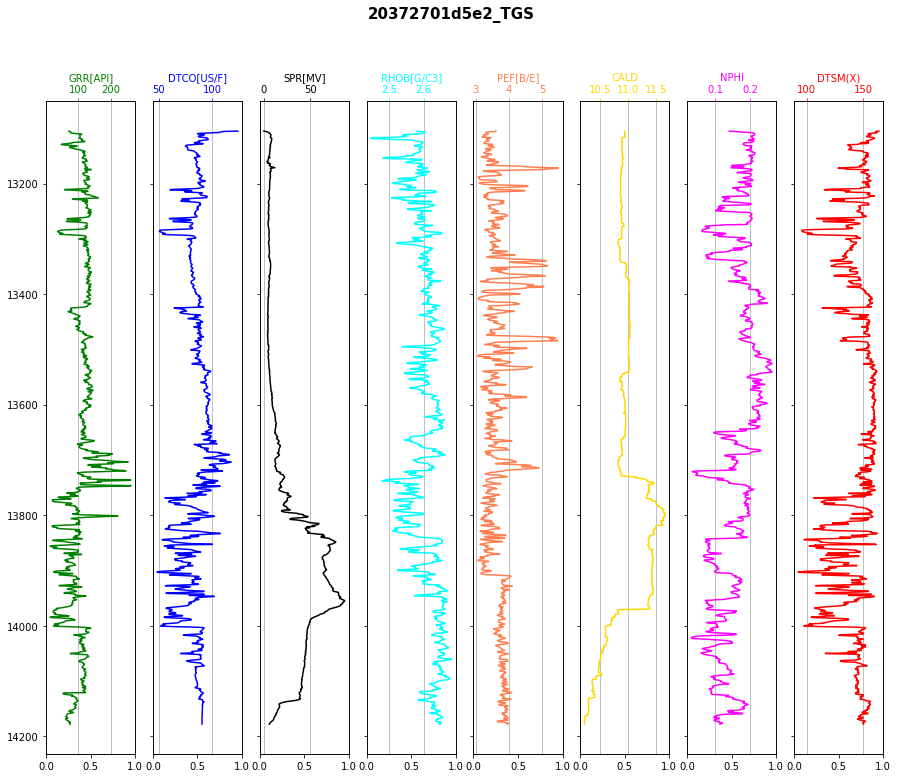

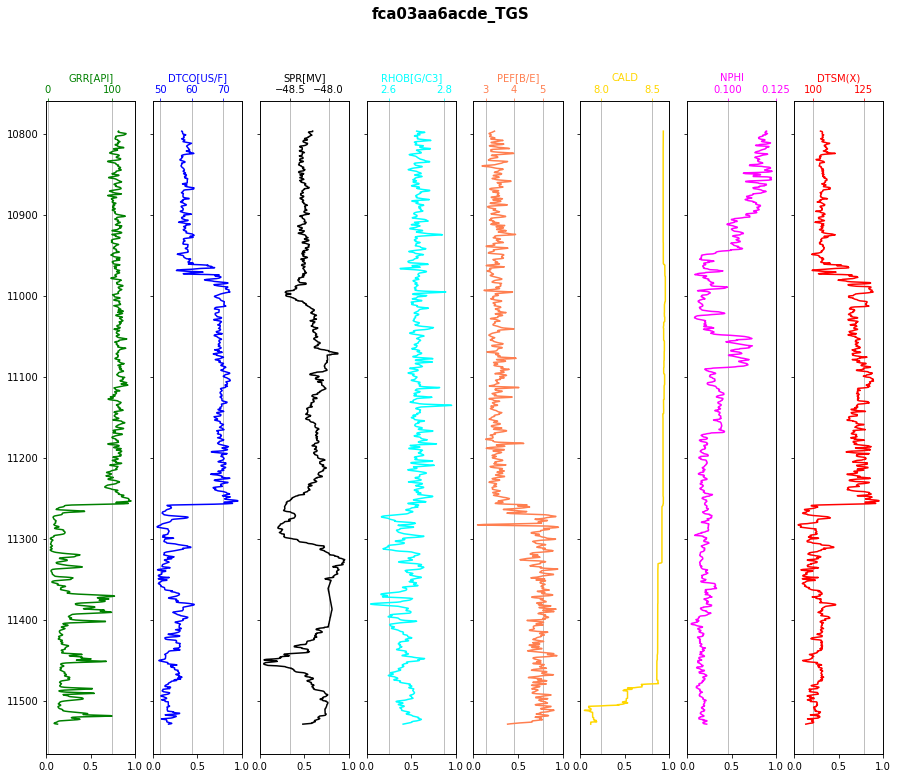

/Users/hpratama/opt/miniconda3/envs/jcopml/lib/python3.7/site-packages/openpyxl/worksheet/_writer.py:110: ResourceWarning: unclosed file <_io.BufferedReader name='Samsan-Tech/Leaderboard/302460e3021a_TGS.xlsx'>
  for (row, col), cell in sorted(self.ws._cells.items()):


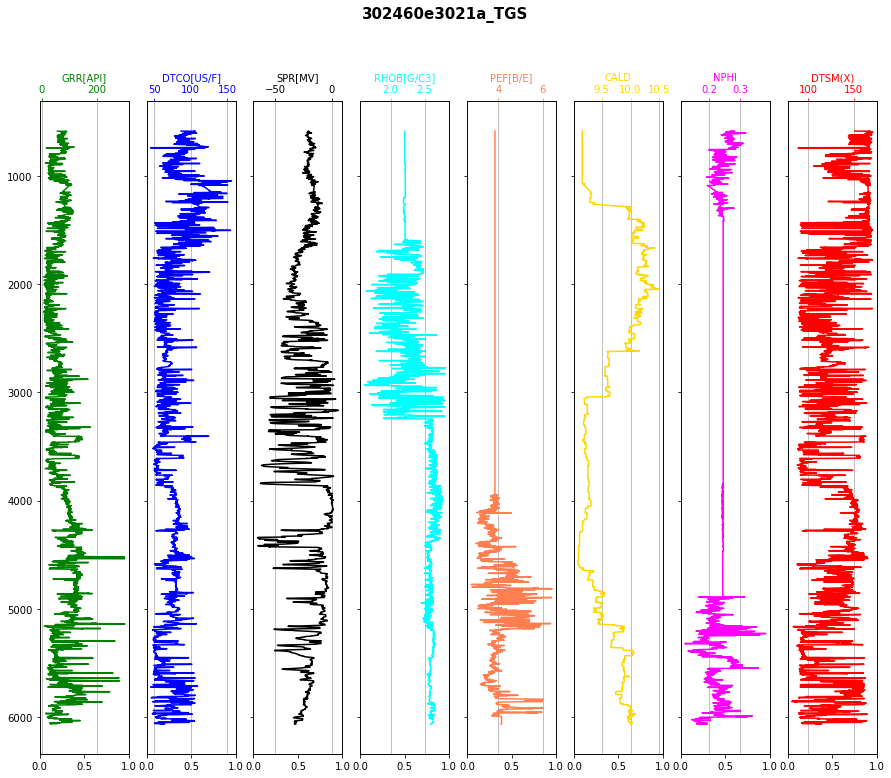

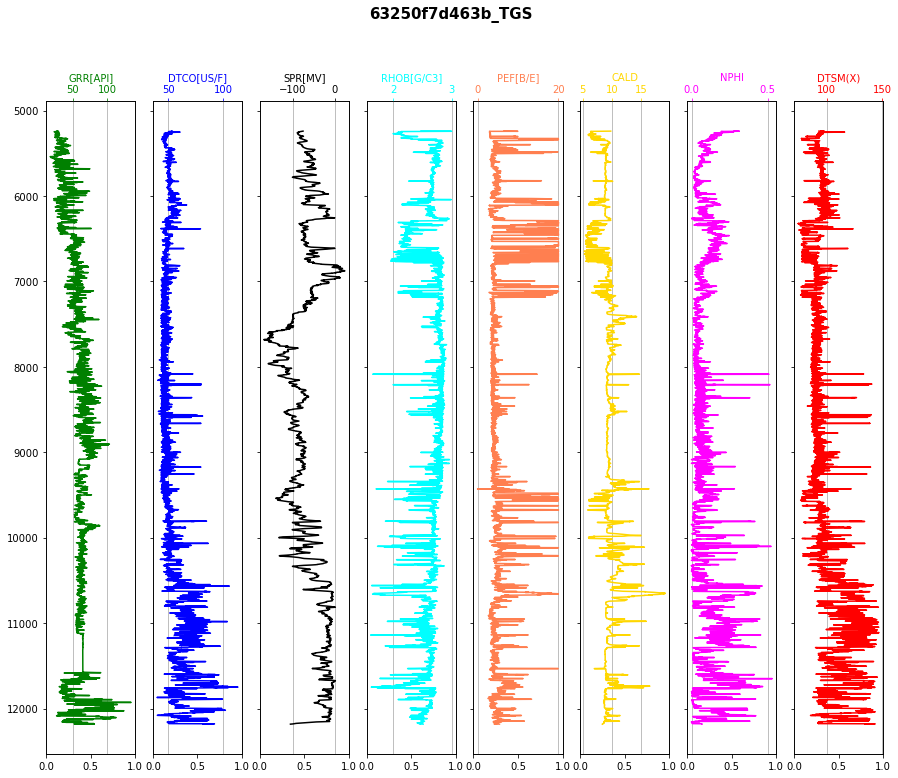

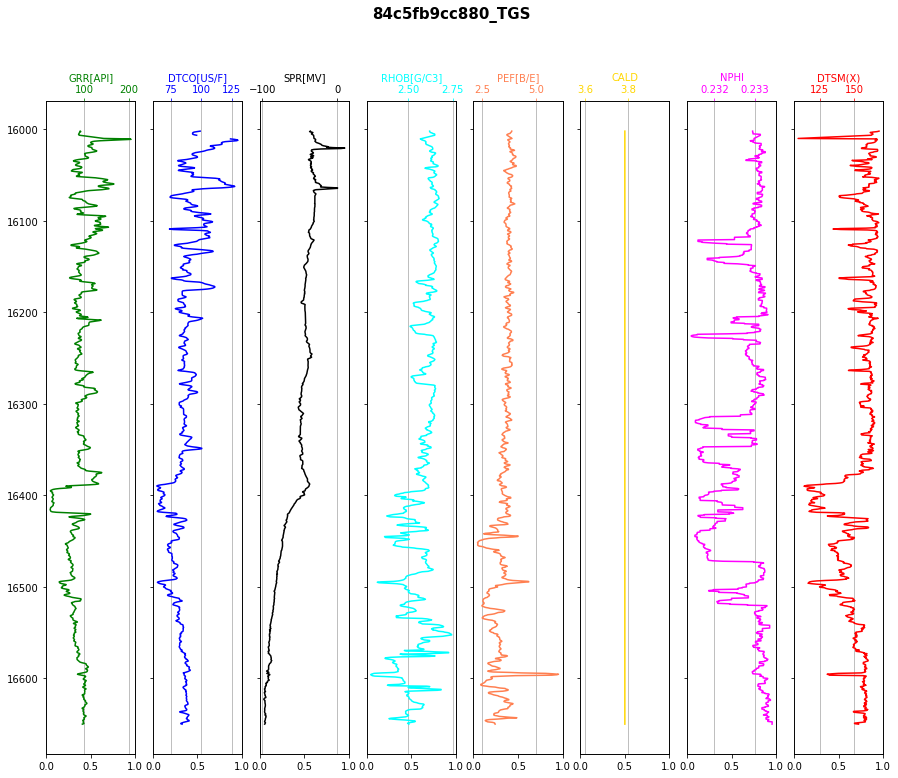

/Users/hpratama/opt/miniconda3/envs/jcopml/lib/python3.7/threading.py:227: ResourceWarning: unclosed file <_io.BufferedReader name='Samsan-Tech/Leaderboard/0a7822c59487_TGS.xlsx'>
  self._release_save = lock._release_save


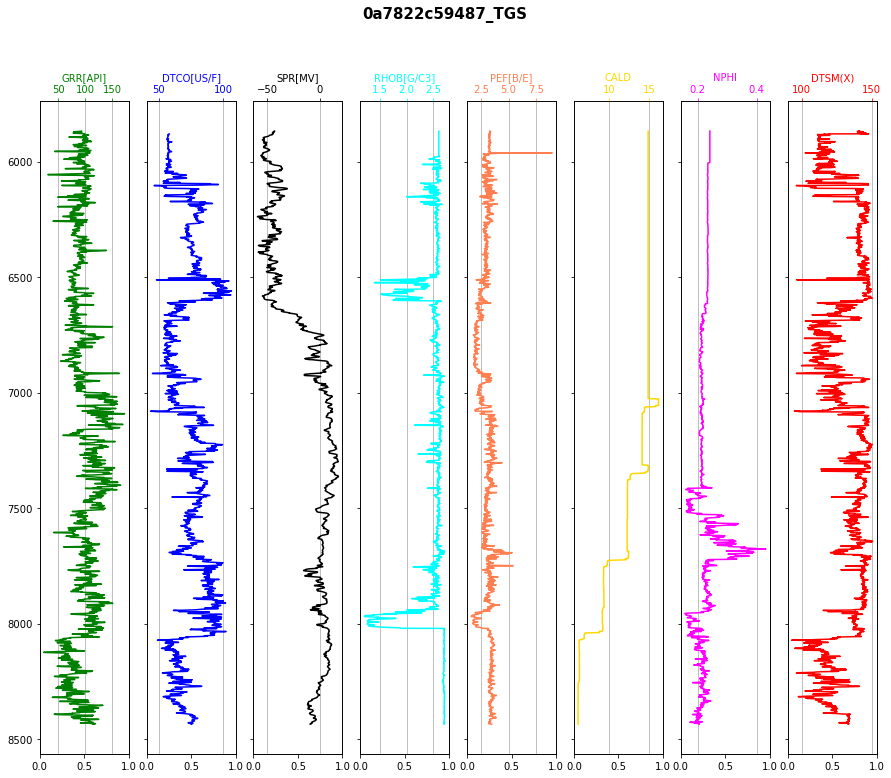

/Users/hpratama/opt/miniconda3/envs/jcopml/lib/python3.7/contextlib.py:82: ResourceWarning: unclosed file <_io.BufferedReader name='Samsan-Tech/Leaderboard/ff7845ea074d_TGS.xlsx'>
  self.gen = func(*args, **kwds)


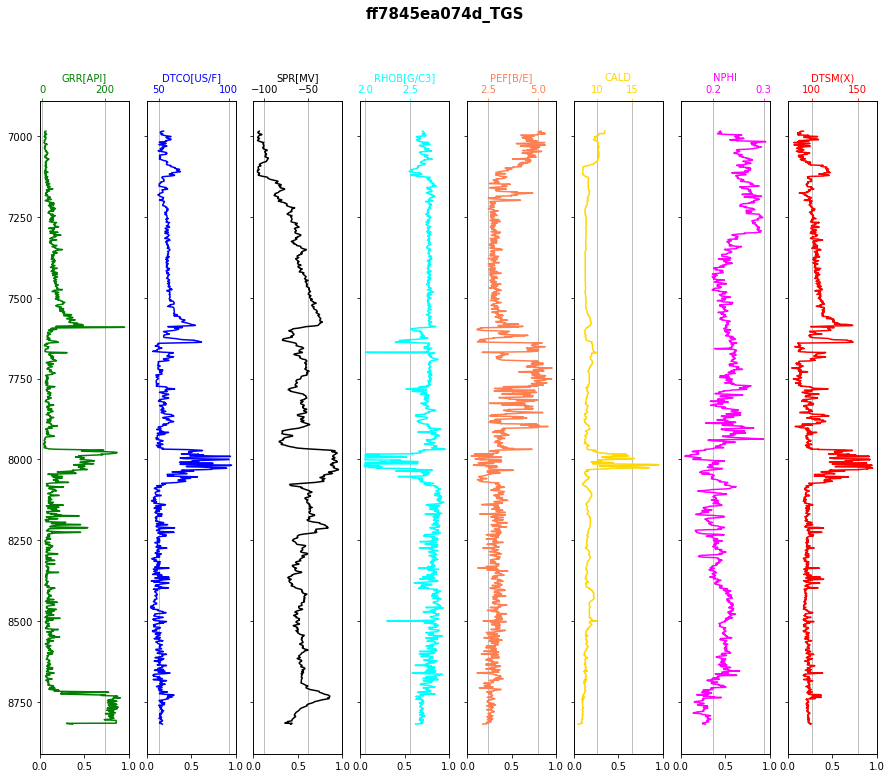

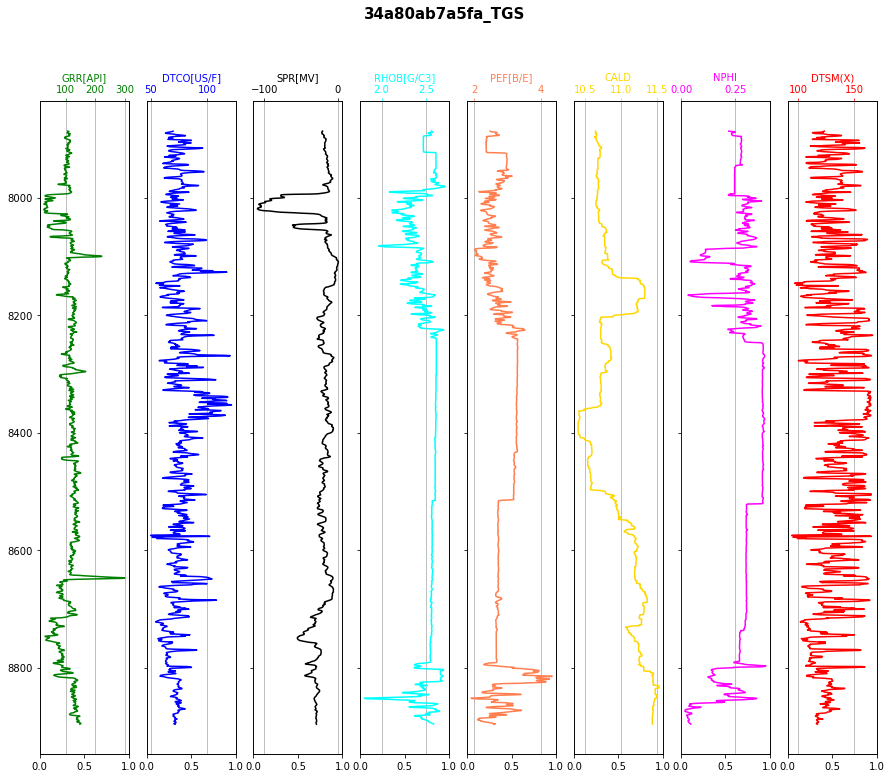

/Users/hpratama/opt/miniconda3/envs/jcopml/lib/python3.7/xml/etree/ElementTree.py:1554: ResourceWarning: unclosed file <_io.BufferedReader name='Samsan-Tech/Leaderboard/34a80ab7a5fa_TGS.xlsx'>
  return self.target.start(tag, attrib)
/Users/hpratama/opt/miniconda3/envs/jcopml/lib/python3.7/contextlib.py:82: ResourceWarning: unclosed file <_io.BufferedReader name='Samsan-Tech/Leaderboard/eed1e9537976_TGS.xlsx'>
  self.gen = func(*args, **kwds)


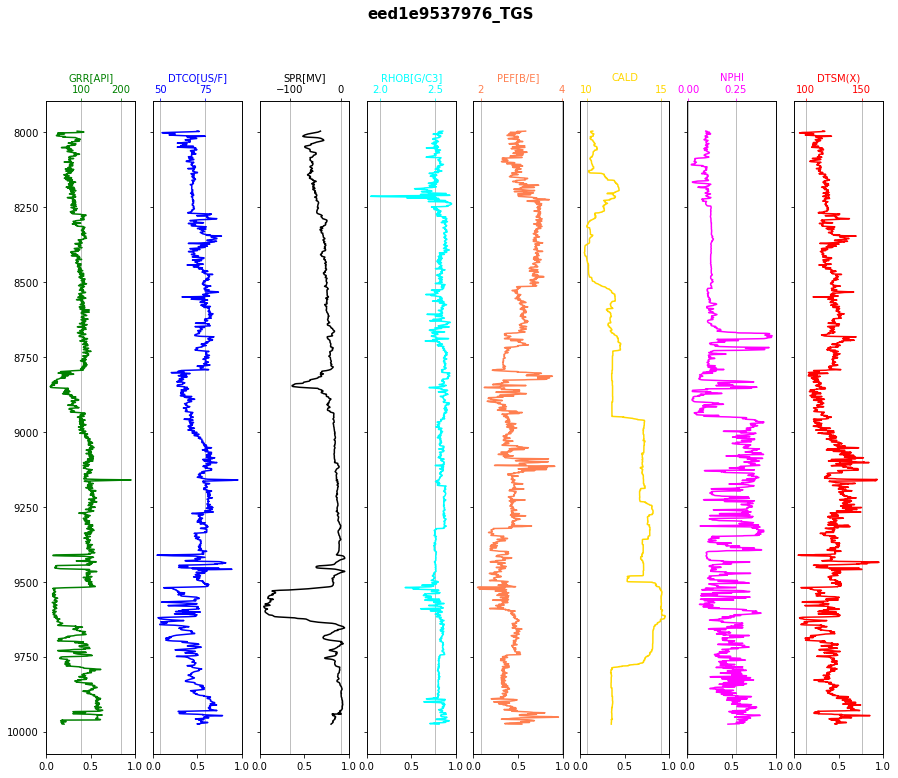

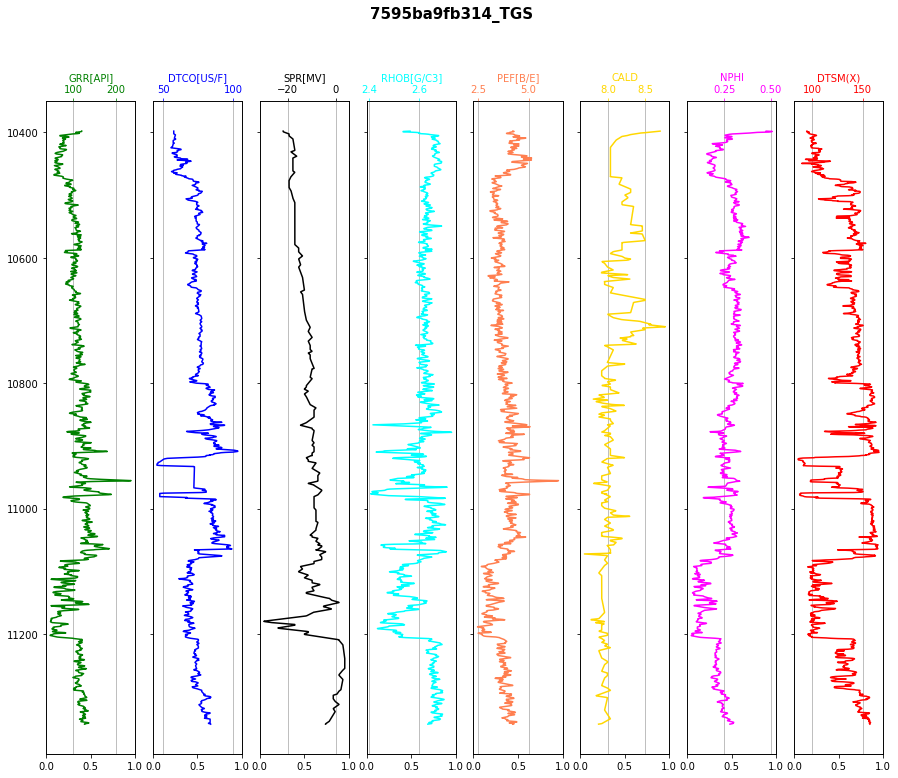

/Users/hpratama/opt/miniconda3/envs/jcopml/lib/python3.7/site-packages/openpyxl/worksheet/_writer.py:111: ResourceWarning: unclosed file <_io.BufferedReader name='Samsan-Tech/Leaderboard/7595ba9fb314_TGS.xlsx'>
  rows[row].append(cell)


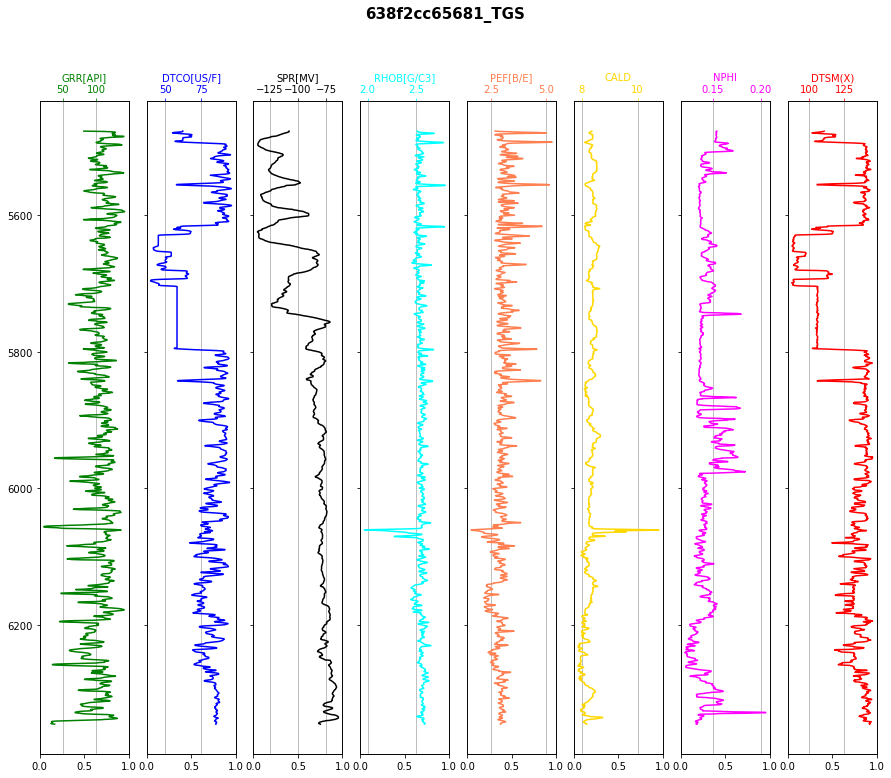

/Users/hpratama/opt/miniconda3/envs/jcopml/lib/python3.7/site-packages/openpyxl/cell/cell.py:109: ResourceWarning: unclosed file <_io.BufferedReader name='Samsan-Tech/Leaderboard/8e37531ba266_TGS.xlsx'>
  super(Cell, self).__init__(worksheet, style_array)


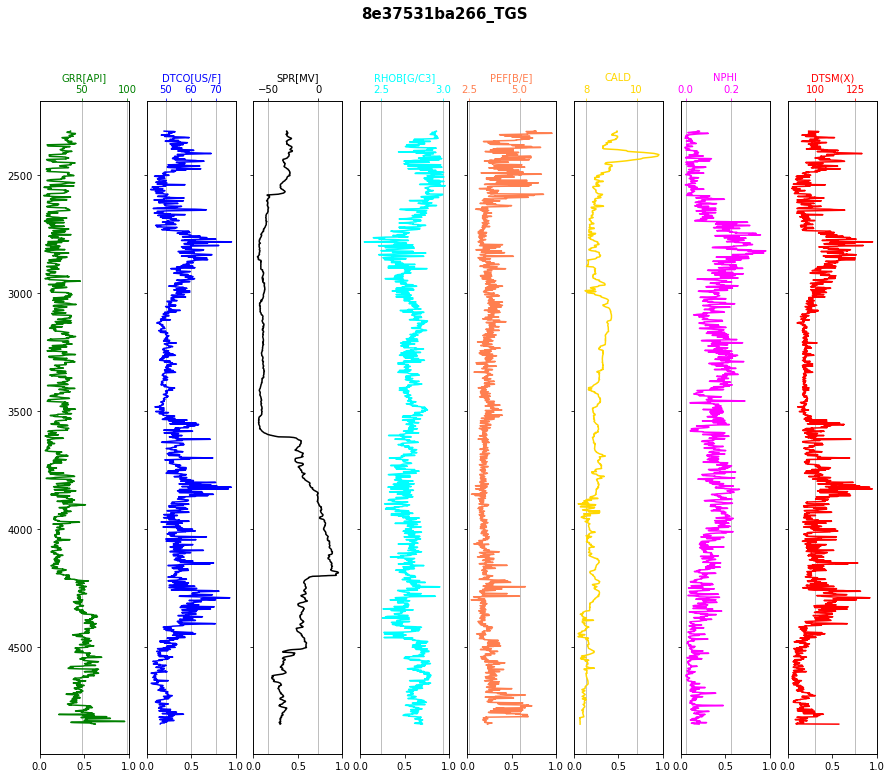

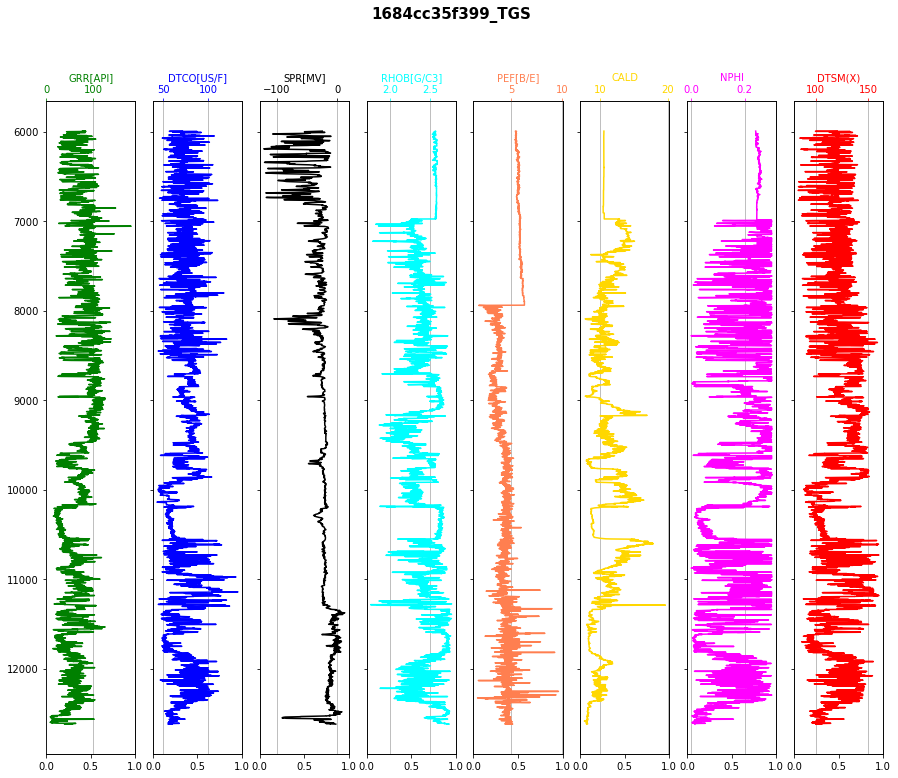

/Users/hpratama/opt/miniconda3/envs/jcopml/lib/python3.7/site-packages/openpyxl/cell/cell.py:109: ResourceWarning: unclosed file <_io.BufferedReader name='Samsan-Tech/Leaderboard/ae16a9f64878_TGS.xlsx'>
  super(Cell, self).__init__(worksheet, style_array)


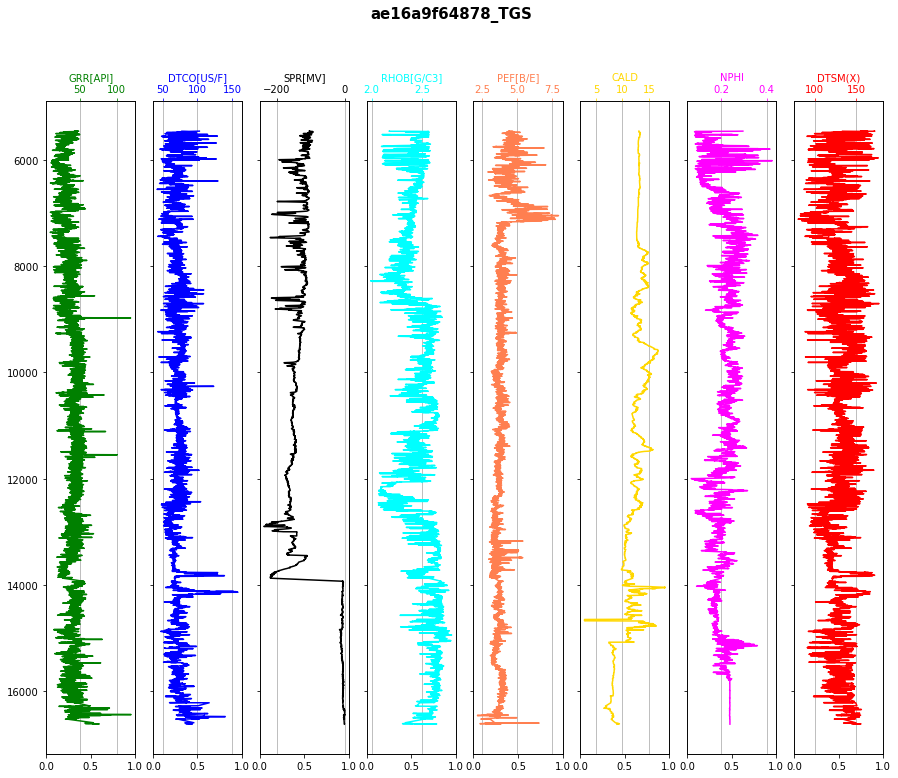

/Users/hpratama/opt/miniconda3/envs/jcopml/lib/python3.7/site-packages/openpyxl/cell/cell.py:109: ResourceWarning: unclosed file <_io.BufferedReader name='Samsan-Tech/Leaderboard/ed48bda2217f_TGS.xlsx'>
  super(Cell, self).__init__(worksheet, style_array)


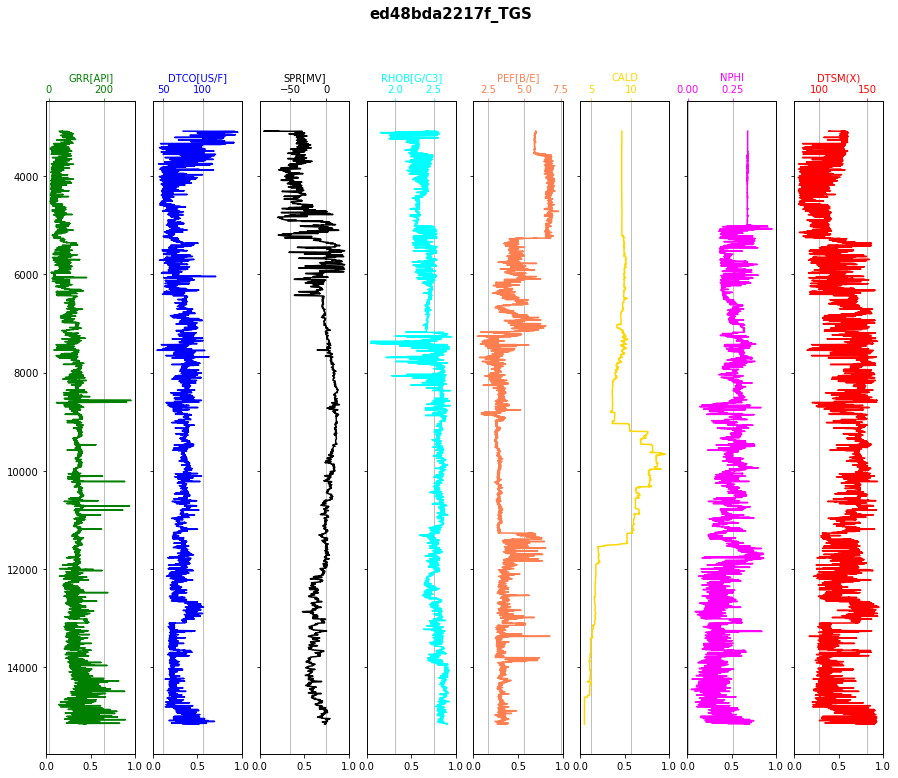

In [8]:
for filename in tqdm(os.listdir(os.getcwd()+'/FinalCSV/')):
    well = filename.split('.')[0]
    predict(well)